# Quantum computation in (1+1)D scalar field theory

Mostly a copy of Christian's Mathematica notebook, with some minor tweaks to speed up performance

## Initialization

Create a lattice class which can be used by operator creation functions to correctly place operators on the lattice. Holds basic lattice attributes and computes spacing on both the physical and field lattice, assuming the fields are digitized in the position representation.

(Would be nice to extend this to check behavior with other representations, but I think this would require rethinking the class structure substantially.)

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%matplotlib inline
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg
from itertools import product
import gmpy2

In [3]:
class Lattice:
    """ Lattice class. Holds relevant information about the qubit lattice
        we want to use. Certain helper quantites are initialized to useful
        default values but can be reset if desired.
        
        In particular, field digitization is set for optimum performance
        assuming a free scalar field theory, which
    """
    
    def __init__(self, nL, nQ, dx=1, twist=0):
        """ Construct a physical lattice with nL sites of nQ qubits each.
            Lattice spacing and twist (in units of pi) can be provided.
        """
        self.dx, self.twist = dx, twist
        self.nL, self.nQ = nL, nQ
        
        # self.phiMax = np.sqrt(1/self.AvgEModes() * np.pi/2 * (self.nPhi() - 1)**2/self.nPhi())
        # Not needed since nQ setter now handles this every time nQ is changed
    
    @property
    def nQ(self):
        return self._nQ
    
    @nQ.setter
    def nQ(self, value):
        self._nQ = value
        self.phiMax = np.sqrt(1/self.AvgEModes() * np.pi/2 * (self.nPhi() - 1)**2/self.nPhi())
    
    def __repr__(self):
        ''' Print out constructor for state. '''
        return 'Lattice(nL={}, nQ={}, dx={}, twist={})'.format(self.nL, self.nQ, self.dx, self.twist)
        
    def __str__(self):
        """ Print out a basic description of the lattice. """
        return "{}-site lattice with {} qubits/site. \nlattice spacing: a = {}, boundary phase shift: theta = {:.2f}".format(nL, nQ, dx, self.theta())

    def theta(self):
        return np.pi*self.twist

    def nPhi(self):
        return 2**self.nQ
    
    def EModes(self):
        """ A helper function to compute the mode frequencies assuming a free
            field theory. Used to initialize the field spacing for the digitized
            field representation. """
        return 2 * np.sqrt(np.sin(self.dx * self.pLattice()/2)**2)
    
    def AvgEModes(self):
        """ A helper function to compute average mode energy assuming a free
            theory. Used to initialize the field spacing for the digitized
            field representation.
        """
        return np.average( self.EModes() )
    
    def xLattice(self, offset=0):
        """ Return physical lattice.
            First site is at 0 by default, but can be adjusted by changing offset.
            (This has no physical effect, but might be useful for plot formatting.)
        """
        return np.linspace(0 + offset, self.dx*self.nL + offset, self.nL, endpoint=False, dtype=float)
    
    def pLattice(self):
        """ Return momentum (reciprocal) lattice. 
            The momentum lattice is determined by the choice of twist variable,
            which is useful to avoid dealing with the p = 0 mode, but whose
            physical effect should vanish at nL increases.
        """
        dp = 2*np.pi/(self.nL*self.dx)
        p_lat = np.linspace(dp*self.twist/2, dp*(self.nL+self.twist/2), self.nL, endpoint=False)
#        p_max = np.pi/self.dx if self.nL%2 == 0 else np.pi/self.dx * (self.nL-1)/self.nL # Technically only maximum momentum if twist = 0
#        p_lat = np.linspace(-p_max - self.theta()/(self.dx*self.nL),
#                            -p_max + 2*np.pi/self.dx - self.theta()/(self.dx*self.nL), self.nL, endpoint=False)
        return p_lat
    
    def phiLattice(self):
        """ Return field value lattice. """
        return np.linspace(-self.phiMax, self.phiMax, self.nPhi())
    
    def piLattice(self):
        """ Return conjugate field (field momentum) lattice. """
        piMax = np.pi/(2*self.phiMax) * (self.nPhi() -1)**2/self.nPhi()
        return np.linspace(-piMax, piMax, self.nPhi())
        
nL = 3 # Number of lattice sites
dx = 1 # Lattice spacing, usually called a in the lattice literature
twist = 1 # Physical lattice twist in units of pi
#twist = -1 if nL%2 == 0 else 1 # Christian's twist convention, only affects momentum indexing

nQ = 3 # Number of qubits per lattice site

Lat = Lattice(nL, nQ, dx, twist)
print(Lat)

Lat1 = Lattice(nL, 1, dx, twist)
Lat2 = Lattice(nL, 2, dx, twist)
Lat3 = Lattice(nL, 3, dx, twist)
Lat4 = Lattice(nL, 4, dx, twist)

g = 0.3 # Wilson line coupling constant

3-site lattice with 3 qubits/site. 
lattice spacing: a = 1, boundary phase shift: theta = 3.14


## Fourier transforms

Eventually want to use `np.fft` methods to speed things up, but I'm confused how arbitrary twists should be implemented, so for now let's just hardcode the DFT matrices

In [4]:
def DFT_phi(N):
    i, j = np.meshgrid(np.linspace(-(N-1)/2, (N-1)/2, N), np.linspace(-(N-1)/2, (N-1)/2, N))
    omega = np.exp( 2 * np.pi * 1j / N )
    W = np.power( omega, i * j ) / np.sqrt(N)
    return W

def iDFT_phi(N):
    W = DFT_phi(N).conj().T
    return W

## Single site operators

For now, avoid using `scipy.sparse` matrices. Rule of thumb online seems to be that a sparsity of $\le 0.01$ is needed to beat the efficienty of NumPy arrays due to overheads.

In [5]:
def idOp(lattice):
    return np.identity(lattice.nPhi())

def phiOp(lattice):
    return np.diag(lattice.phiLattice())

def phi2Op(lattice):
    return np.diag(lattice.phiLattice()**2)

def phi4Op(lattice):
    return np.diag(lattice.phiLattice()**4)

def ipiOp(lattice, tol=13):
    ipi_diagOp = np.diag(-1j*lattice.piLattice())
    return (iDFT_phi(lattice.nPhi()) @ ipi_diagOp @ DFT_phi(lattice.nPhi())).round(tol)

def ipidagOp(lattice, tol=13):
    ipidag_diagOp = np.diag(1j*lattice.piLattice())
    return (iDFT_phi(lattice.nPhi()) @ ipidag_diagOp @ DFT_phi(lattice.nPhi())).round(tol)

def pi2Op(lattice, tol=13):
    pi2_diagOp = np.diag(lattice.piLattice()**2)
    return (iDFT_phi(lattice.nPhi()) @ pi2_diagOp @ DFT_phi(lattice.nPhi())).round(tol)  

### SHO test

In [6]:
def SHOOp(lattice):
    maxE = lattice.EModes()[math.floor(lattice.nL/2)]
    return 0.5*(pi2Op(lattice) + maxE**2*phi2Op(lattice))

Text(0, 0.5, '$\\psi$')

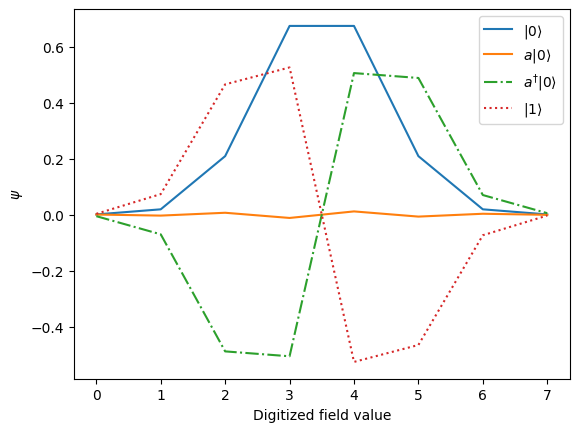

In [7]:
# Find lowest eigenstate ~ vacuum of SHO
# Define analogues of raising/lowering operators,
#   check that they approximately anihilate the vacuum + reproduce exited state

eigenvects = np.linalg.eig(SHOOp(Lat))[1].T
eigenvals = np.linalg.eig(SHOOp(Lat))[0]

#Be warned that the eigenvalues are not sorted by default (!)
eigenvects = [x for _,x in sorted(zip(eigenvals,eigenvects))]
eigenvals = np.sort(eigenvals)

vac = eigenvects[0]
maxE = Lat.EModes()[math.floor(Lat.nL/2)]
a_op = np.sqrt(maxE)/np.sqrt(2)*(phiOp(Lat) + 1/maxE * ipiOp(Lat))
adag_op = np.sqrt(maxE)/np.sqrt(2)*(phiOp(Lat) - 1/maxE * ipiOp(Lat))

plt.plot(np.real(vac),label=r"$|0\rangle$")
plt.plot(np.real(a_op @ vac),label=r"$a |0\rangle$")
plt.plot(np.real(adag_op @ vac),label=r"$a^\dag |0\rangle$",ls="-.")
plt.plot(np.real(eigenvects[1]),label=r"$|1\rangle$",ls=":") #only defined up to a sign so can be mirrored.
plt.legend()
plt.xlabel("Digitized field value")
plt.ylabel(r'$\psi$')

Text(0, 0.5, '$\\psi$')

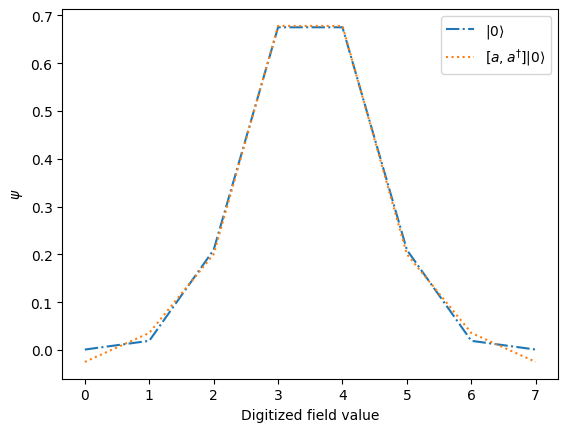

In [8]:
# A couple more checks
#  act on vacuum with [a, a^dag] ~ 1 + check accuracy of BCH reduction of coherent state

plt.plot(np.real(vac),label=r"$|0\rangle$",ls="-.")
plt.plot(np.real( (a_op @ adag_op - adag_op @ a_op) @ vac ),label=r"$[a,a^\dag] |0\rangle$",ls=":")
plt.legend()
plt.xlabel("Digitized field value")
plt.ylabel(r'$\psi$')

## Multi-site operators via Kronecker products

In [9]:
def operatorSite(opTup, posTup, lattice):
    """ Takes a tuple of operators and positions, and returns the Kronecker
        product of these on the specified lattice. Applies appropriate twist
        if operator position is outside the first Brouillin zone (0, nL-1).
        
        op is a tuple of functions of the form op(lattice) that are assumed to
        have already been defined. If this is not the case, the function will
        fail unexpectedly.
        
        pos is a tuple of positions, none of which can appear twice when
        projected to the first Bruillin zone, otherwise an exception is raised.
        
        !!! Has a known bug if the operator is itself a function of other
            operators, e.g., a Wilson line. The operators inside the function
            don't pick up required phases when moved back to the first BZ.
    """
    posList, phaseList = [], []
    for pos in posTup:
        wrapnum, posnum = divmod(pos, lattice.nL)
        phase = np.exp(1j*wrapnum*lattice.theta()).round(13)
        
        posList.append(posnum)
        phaseList.append(phase)
        
    if max([posList.count(x) for x in set(posList)]) > 1:
        raise Exception("More than one operator per lattice site!")
    
    opList = [idOp(lattice)] * lattice.nL
    
#    print(phaseList, posList)
        
    for op, pos, phase in zip(opTup, posList, phaseList):
        opList[pos] = phase*op

    fullOp = np.array([1])
    for op in opList:
        fullOp = np.kron(fullOp, op)
        
    return fullOp

## Hamiltonian

In [10]:
def HamiltonianPi(lattice):
    return lattice.dx * 0.5 * np.sum([operatorSite([pi2Op(lattice)], [i], lattice) for i in range(lattice.nL)], axis=0)

def HamiltonianPhi(lattice, lam=0):
    kinterm = -1./lattice.dx**2 * np.sum([operatorSite([phiOp(lattice),phiOp(lattice)],[i,i-1],lattice)
                                         + operatorSite([phiOp(lattice),phiOp(lattice)],[i,i+1],lattice)
                                         - 2*operatorSite([phi2Op(lattice)],[i],lattice) for i in range(lattice.nL)], axis=0)
    intterm = 0. if lam==0 else lam * np.sum([operatorSite([phi4Op(lattice)], [i], lattice) for i in range(lattice.nL)], axis=0)
    return lattice.dx * (0.5 * kinterm + (1/math.factorial(4)) * intterm)

def Hamiltonian(lattice, lam=0):
    ''' Create Hamiltonian for a massless scalar field theory.
        Optional quartic coupling can be set'''
    return HamiltonianPi(lattice) + HamiltonianPhi(lattice, lam)

In [11]:
myeigs = np.linalg.eig(Hamiltonian(Lat))
hamEigen = np.sort(np.absolute(myeigs[0]))

In [12]:
print('The first few eigvanlues:\n{}'.format(np.round(hamEigen[0:12],8)))

The first few eigvanlues:
[2.00007223 2.99958059 2.99958059 3.99927475 4.00123595 4.00123595
 4.00339598 4.99379346 4.99379346 4.99464398 5.00336403 5.00336403]


In [13]:
excitations = list(product(list(range(Lat.nPhi())), repeat=Lat.nL))
hamEigenExact = [sum([(0.5 + excitations[i][j])*Lat.EModes()[j] for j in range(Lat.nL)]) for i in range(len(excitations))]

excitations = [x for _,x in sorted(zip(hamEigenExact,excitations))]
hamEigenExact = np.sort(hamEigenExact)

In [14]:
for i in range(12):
    print("E = {:.2f} for state = {}".format(hamEigenExact[i], excitations[i]))

E = 2.00 for state = (0, 0, 0)
E = 3.00 for state = (1, 0, 0)
E = 3.00 for state = (0, 0, 1)
E = 4.00 for state = (0, 1, 0)
E = 4.00 for state = (2, 0, 0)
E = 4.00 for state = (1, 0, 1)
E = 4.00 for state = (0, 0, 2)
E = 5.00 for state = (1, 1, 0)
E = 5.00 for state = (2, 0, 1)
E = 5.00 for state = (3, 0, 0)
E = 5.00 for state = (0, 1, 1)
E = 5.00 for state = (0, 0, 3)


Text(0, 0.5, 'Fractional Error in Eigenvalue')

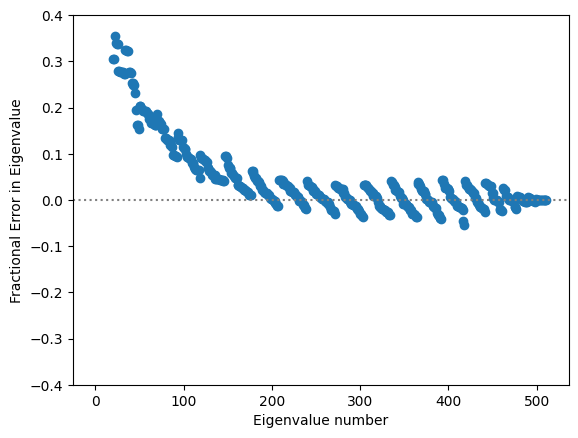

In [15]:
plt.plot((hamEigen[::-1]-hamEigenExact[::-1])/hamEigenExact[::-1],marker='o',ls="none")
#Christian's plot starts with the biggest ones first so reverse the order.
plt.axhline(0,ls=":",color="grey")
plt.ylim([-0.4,0.4])
plt.xlabel("Eigenvalue number")
plt.ylabel("Fractional Error in Eigenvalue")

## Time evolution

In [16]:
def expHamiltonianPi(t, lattice):
    return scipy.linalg.expm(-1.j * t * HamiltonianPi(lattice))

def expHamiltonianPhi(t, lattice, lam=0):
    return scipy.linalg.expm(-1.j * t * HamiltonianPhi(lattice, lam))

def evolveH(t, lattice, lam=0):
    return scipy.linalg.expm(-1.j * t *Hamiltonian(lattice, lam))

def evolveHTrotter(t, n, lattice, lam=0):
    return np.linalg.matrix_power(expHamiltonianPi(t/n, lattice) @ expHamiltonianPhi(t/n, lattice, lam),n)

In [17]:
myeigs_trotter = np.linalg.eig(evolveHTrotter(1, 2000, Lat))
print("Lowest few eigenvalues of Trotterized H evolution: {}".format(np.sort(np.real(myeigs_trotter[0]))[0:10]))

Lowest few eigenvalues of Trotterized H evolution: [-0.99991184 -0.99906259 -0.99900198 -0.99844776 -0.99844776 -0.99562933
 -0.99529612 -0.99529612 -0.99522825 -0.99237334]


In [18]:
nsteps = 25
myvals = np.zeros([nsteps,Lat.nPhi()**Lat.nL])
for i in range(nsteps):
    myeigs_trotter = np.linalg.eig(evolveHTrotter(1,i+1, Lat))
    myvals[i,:] = np.sort(np.real(myeigs_trotter[0]))

Text(0, 0.5, 'Re($\\lambda_i$)')

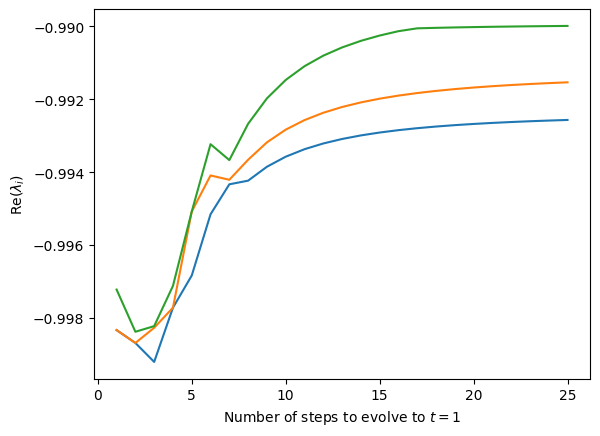

In [19]:
# See how many steps it takes a few eigenvalues to stablize
# The discontinuous jumps in the middle are due to level crossings, but I don't
# know if there's a way to be smarter about tracking them
plt.plot(range(1,nsteps+1),myvals[:,9:12])
plt.xlabel(r'Number of steps to evolve to $t=1$')
plt.ylabel(r'Re($\lambda_i$)')

## State preparation

In [20]:
def KitaevWebbDMDecomposition(input_mat):
    #https://arxiv.org/abs/0801.0342
    g = np.linalg.cholesky(input_mat)
    d = np.real(np.diag(np.diag(g)**2))
    l = np.real(g @ np.diag(np.diag(g)**-1))
    m = np.linalg.inv(l.conj().T)
    return d,m,g

matrixDim = 6
A = np.random.rand(matrixDim, matrixDim)
Cov = A @ A.T
print('The random matrix is\n {}'.format(Cov))

d,m,g = KitaevWebbDMDecomposition(Cov)

print('Put it back together\n {}'.format( np.linalg.inv(m.T) @ d @ np.linalg.inv(m) ))

The random matrix is
 [[2.85781266 1.08719746 1.53677553 1.85474204 2.36148109 1.72221329]
 [1.08719746 1.03970853 0.98942424 0.8108434  1.29284185 1.4151798 ]
 [1.53677553 0.98942424 1.68760077 0.72777162 1.42276004 1.73397292]
 [1.85474204 0.8108434  0.72777162 1.86369273 2.00882208 1.03012777]
 [2.36148109 1.29284185 1.42276004 2.00882208 2.51341982 1.83280305]
 [1.72221329 1.4151798  1.73397292 1.03012777 1.83280305 2.15540144]]
Put it back together
 [[2.85781266 1.08719746 1.53677553 1.85474204 2.36148109 1.72221329]
 [1.08719746 1.03970853 0.98942424 0.8108434  1.29284185 1.4151798 ]
 [1.53677553 0.98942424 1.68760077 0.72777162 1.42276004 1.73397292]
 [1.85474204 0.8108434  0.72777162 1.86369273 2.00882208 1.03012777]
 [2.36148109 1.29284185 1.42276004 2.00882208 2.51341982 1.83280305]
 [1.72221329 1.4151798  1.73397292 1.03012777 1.83280305 2.15540144]]


In [21]:
def GPhi(i, j, lattice, tol=13):
    x = lattice.xLattice()
    modeweight = lattice.EModes() * np.exp(1j*lattice.pLattice()*(x[i] - x[j]))
    return (1/lattice.nL)*np.sum(modeweight).round(tol)

def GPhiMatrix(lattice, tol=13):
    return [[GPhi(i,j, lattice) for j in range(lattice.nL)] for i in range(lattice.nL)]

In [22]:
def toPhiList(pos, lattice):
    return np.array([lattice.phiLattice()[int(gmpy2.digits(pos, lattice.nPhi()).zfill(lattice.nL)[i])] for i in range(lattice.nL)])

def KitaevWebbDMDecomposition(input_mat):
    #https://arxiv.org/abs/0801.0342
    g = np.linalg.cholesky(input_mat)
    d = np.real(np.diag(np.diag(g)**2))
    l = np.real(g @ np.diag(np.diag(g)**-1))
    m = np.linalg.inv(l.conj().T)
    return d,m,g

def createEigenstate(exlist, lattice):
    ''' Creates the normalized wavefunction for a digitized approximation
        of an energy eigenstate for a 1D lattice. 
          exlist: occupation numbers for momentum modes in the order given
                  by lattice.EModes(). [0, ..., 0] is the ground state
    '''
    if len(exlist) != lattice.nL:
        raise TypeError('Mode list incompatible with lattice size!')
    wavefun = np.zeros(lattice.nPhi()**lattice.nL, dtype=complex)
    x = lattice.xLattice()
    p = lattice.pLattice()
    phicov = GPhiMatrix(lattice)
    
    for i in range(lattice.nPhi()**lattice.nL):
        philist = toPhiList(i, lattice)
        expfactor = np.exp(-0.5 * philist @ phicov @ philist)
        
        terms = np.zeros(lattice.nL, dtype=complex)
        for n, nk in enumerate(exlist):
            Hcoeff = np.zeros(nk+1)
            Hcoeff[nk] = 1
            field = np.sqrt(lattice.EModes()[n]) * np.sqrt(1/lattice.nL)*np.sum([philist[i]*np.exp(-1j * p[n] * x[i]) for i in range(lattice.nL)])
            term = np.polynomial.hermite.hermval([field], Hcoeff).round(13)
            terms[n] = term
        wavefun[i] = expfactor * np.prod(terms)
    wavefun = wavefun/np.sqrt(np.sum(np.abs(wavefun)**2))
    return wavefun

def createKWground(lattice, ool_keep=True, decompose_shear=False):
    ''' Creates the KW approximationg of the scalar ground state for a given
        lattice, including proper treatment of shear matrices
            ool_keep: keep out-of-digitization-lattice entries by wrapping
                      to other side of lattice (dropping these would require
                      gabage collection on the quantum circuit) [True]
            decompose_shear: original KW procedure where every individual shift
                             is digitized before application [False]
    ''' 
    dcov,mshear,_ = KitaevWebbDMDecomposition(GPhiMatrix(lattice))
    invmshear = np.linalg.inv(mshear)

    ground = np.zeros(lattice.nPhi()**lattice.nL, dtype=complex)
    dphi = 2*lattice.phiMax/(lattice.nPhi()-1)
    
    for i in range(lattice.nPhi()**lattice.nL):
        philist = toPhiList(i, lattice)
        
        #Compute rotated field values after rounding to nearest digitized value
        philist = philist/dphi
        if decompose_shear:
            for j in range(len(invmshear)):
                shifts = np.rint((invmshear[j] * philist)[j+1:])
                philist[j] += np.sum(shifts)
            philist = np.rint(philist + lattice.phiMax/dphi)
        else:
            philist = invmshear @ philist
            philist = np.rint(philist + lattice.phiMax/dphi)

        #Two options for how to deal with out-of-lattice points
        if ool_keep:
            #Option A: wrap out-of-lattice point back to original lattce
            philist = np.mod(philist, lattice.nPhi())
            philist = philist*dphi - lattice.phiMax
        
            expfactor = np.exp(-0.5 * philist @ dcov @ philist)
        if not ool_keep:
            #Option B: just drop them (requires garbage collection in qcircuit)
            ool = any(id < -0.1 or id > lattice.nPhi() - 0.1 for id in philist)
            philist = philist*dphi - lattice.phiMax
        
            expfactor = np.exp(-0.5 * philist @ dcov @ philist) if not ool else 0.
            
        ground[i] = expfactor
            
    ground = ground/np.sqrt(np.sum(np.abs(ground)**2))
    return ground

def createKWstate(exlist, lattice):
    ''' !!! This method should be considered depreciated, as it does not yield
            a consistent state preparation on most lattices. To simulate what
            should be possible on an actual circuit, a combination of
            createKWground and action by adagop on the resulting state should
            be used.
        Creates the normalized wavefunction for the approximation
        of an energy eigenstate for a 1D lattice using the correlation
        of the Kitaev-Webb procedure.
        NB: Currently does not actually construct the KW state, since
        the shear matrix is not applied.
          exlist: occupation numbers for momentum modes in the order given
                  by lattice.EModes(). [0, ..., 0] is the ground state
    '''
    if len(exlist) != lattice.nL:
        raise TypeError('Mode list incompatible with lattice size!')
    wavefun = np.zeros(lattice.nPhi()**lattice.nL, dtype=complex)
    x = lattice.xLattice()
    p = lattice.pLattice()
    phicov = KitaevWebbDMDecomposition(GPhiMatrix(lattice))[0]
    
    for i in range(lattice.nPhi()**lattice.nL):
        philist = toPhiList(i, lattice)
        expfactor = np.exp(-0.5 * philist @ phicov @ philist)
        
        terms = np.zeros(lattice.nL, dtype=complex)
        for n, nk in enumerate(exlist):
            Hcoeff = np.zeros(nk+1)
            Hcoeff[nk] = 1
            field = np.sqrt(lattice.EModes()[n]) * np.sqrt(1/lattice.nL)*np.sum([philist[i]*np.exp(-1j * p[n] * x[i]) for i in range(lattice.nL)])
            term = np.polynomial.hermite.hermval([field], Hcoeff).round(13)
            terms[n] = term
        wavefun[i] = expfactor * np.prod(terms)
    wavefun = wavefun/np.sqrt(np.sum(np.abs(wavefun)**2))
    return wavefun

In [23]:
def aop(k, lattice):
    ''' Lowering operator for mode k of given lattice. '''
    x = lattice.xLattice()
    p = lattice.pLattice()
    # Hack to fix reversed indexing behavior relative to the direct state creation code that I don't understand
    k = lattice.nL - 1 - k
    
    pre = np.sqrt(lattice.EModes()[k]/(2*lattice.nL))
    phipiece = np.sum([operatorSite([phiOp(lattice)], [i], lattice)*np.exp(-1j * p[k] * x[i]) for i in range(lattice.nL)], axis=0)
    pipiece = np.sum([operatorSite([ipiOp(lattice)], [i], lattice)*np.exp(-1j * p[k] * x[i]) for i in range(lattice.nL)], axis=0)
    return pre * (phipiece + lattice.dx/lattice.EModes()[k] * pipiece)

def adagop(k, lattice):
    ''' Raising operator of mode k of given lattice. '''
    x = lattice.xLattice()
    p = lattice.pLattice()
    # Hack to fix reversed indexing behavior relative to the direct state creation code that I don't understand
    k = lattice.nL - 1 - k    
    
    pre = np.sqrt(lattice.EModes()[k]/(2*lattice.nL))
    phipiece = np.sum([operatorSite([phiOp(lattice)], [i], lattice)*np.exp(-1j * p[k] * x[i]) for i in range(lattice.nL)], axis=0)
    pipiece = np.sum([operatorSite([ipidagOp(lattice)], [i], lattice)*np.exp(-1j * p[k] * x[i]) for i in range(lattice.nL)], axis=0)
    return pre * (phipiece + lattice.dx/lattice.EModes()[k] * pipiece)

In [24]:
#Some plotting utils

def plot_persite(input_vals_list,nq_persite,nsites,labs):
    f = plt.figure(figsize=(5,5))
    
    forplot = np.zeros([nL*2**nQ,len(input_vals_list)])
    for k in range(len(input_vals_list)):
        for i in range(nL):
            for j in range(2**(nQ*nL)):
                qval = int(gmpy2.digits(j,2**nQ).zfill(nL)[i])
                forplot[qval+i*2**nQ,k]+=input_vals_list[k][j]
                pass
            pass
        pass
    
    print(forplot[:,0])
    
    xlabs = []
    for i in range(nL):
        plt.text(2**nQ*i+2**nQ/2-0.5,-0.4,"site "+str(i),horizontalalignment='center')
        if (i > 0):
            plt.axvline(2**nQ*i-0.5,color='grey',ls=":")
        for j in range(2**nQ):
            xlabs += [r'$|'+bin(j)[2:].zfill(nQ)+r'\rangle$']
            pass
        pass
    
    for k in range(len(input_vals_list)):
        plt.plot(forplot[:,k],label=labs[k])
        pass
    plt.ylabel("Pr(site)")
    plt.legend()
    
    plt.xticks(range(nsites*2**nq_persite),xlabs,rotation='vertical',fontsize=10,horizontalalignment='center')

In [25]:
LatHamEfun = np.linalg.eig(Hamiltonian(Lat))[1].T
LatHamEval = np.linalg.eig(Hamiltonian(Lat))[0]

LatHamEfun = [x for _,x in sorted(zip(LatHamEval,LatHamEfun), key=lambda x: x[0])]
LatHamEval = np.sort(LatHamEval)

[0.03675305 0.30683412 1.26249639 2.56077033 2.56077033 1.26249639
 0.30683412 0.03675305 0.03675305 0.30683412 1.26249639 2.56077033
 2.56077033 1.26249639 0.30683412 0.03675305 0.03675305 0.30683412
 1.26249639 2.56077033 2.56077033 1.26249639 0.30683412 0.03675305]


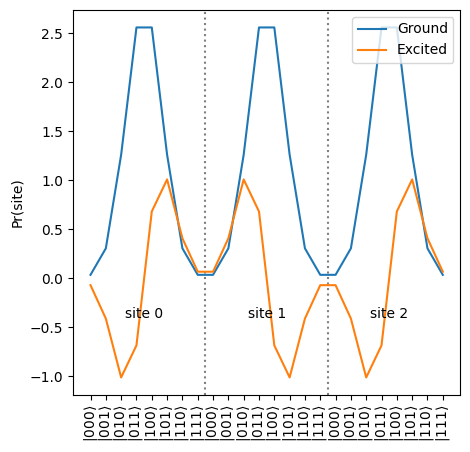

In [26]:
plot_persite([np.real(createEigenstate([0,0,0], Lat)), np.real(createEigenstate([0,1,0], Lat))],Lat.nQ,Lat.nL,labs=['Ground',"Excited"])

[0.03675305 0.30683412 1.26249639 2.56077033 2.56077033 1.26249639
 0.30683412 0.03675305 0.03675305 0.30683412 1.26249639 2.56077033
 2.56077033 1.26249639 0.30683412 0.03675305 0.03675305 0.30683412
 1.26249639 2.56077033 2.56077033 1.26249639 0.30683412 0.03675305]


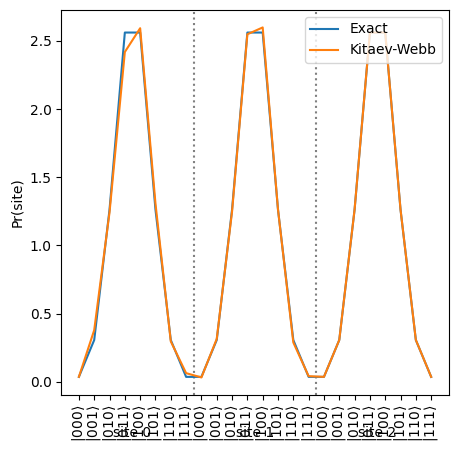

In [27]:
plot_persite([np.real(createEigenstate([0,0,0], Lat)),np.real(createKWground(Lat))],nQ,nL,labs=["Exact","Kitaev-Webb"])

## Wilson Lines

In [28]:
def WLop(g, lattice):
    return scipy.linalg.expm(1j * g * lattice.dx * phiOp(lattice))

def WLdagop(g, lattice):
    return scipy.linalg.expm(-1j * g * lattice.dx * phiOp(lattice))

def WilsonTrotter(g, n, lattice):
    Uop = np.identity(lattice.nPhi()**lattice.nL)
    midp = math.floor(lattice.nL/2)
    for step in range(1,midp+1):
#        print("Now on step {}".format(step+1))
        stepU = operatorSite([WLop(g, lattice)], [midp+step], lattice) @ operatorSite([WLdagop(g, lattice)], [midp-step], lattice) @ evolveHTrotter(lattice.dx, n, lattice)
        Uop = stepU @ Uop
    return Uop

def WilsonEvolve(g, lattice):
    Uop = np.identity(lattice.nPhi()**lattice.nL)
    midp = math.floor(lattice.nL/2)
    for step in range(1,midp+1):
#        print("Now on step {}".format(step+1))
        stepU = operatorSite([WLop(g, lattice)], [midp+step], lattice) @ operatorSite([WLdagop(g, lattice)], [midp-step], lattice) @ evolveH(lattice.dx, lattice)
        Uop = stepU @ Uop
    return Uop

def WilsonNoEvolve(g, lattice):
    Uop = np.identity(lattice.nPhi()**lattice.nL)
    midp = math.floor(lattice.nL/2)
    for step in range(1,midp+1):
#        print("Now on step {}".format(step+1))
        stepU = operatorSite([WLop(g, lattice)], [midp+step], lattice) @ operatorSite([WLdagop(g, lattice)], [midp-step], lattice)
        Uop = stepU @ Uop
    return Uop

## Analytic Comparison

In [29]:
def omega(klist, nL, delta = 0.5):
    ''' Frequency of kth mode (assumes twisted BCs at the moment). '''
    return 2*np.sqrt(np.sum([np.sin(np.pi*(k + delta)/nL)**2 for k in klist]))

def alpha(klist, nL, delta = 0.5):
    ''' Displacement operator shift of resulting coherent state
        after applying Wilson line along first axis.
    '''
    prefactor = 2/np.sqrt(nL) * 1/np.sqrt(2*omega(klist, nL, delta))
    sum = np.sum([np.exp(1j*(s+1)*omega(klist, nL, delta))*np.sin(2*np.pi*(s+1)*(klist[0] + delta)/nL) for s in range(math.floor(nL/2))])
    return prefactor * sum

def transrate(g, nL, exlist):
    ''' Transition rate from ground state to state given by exlist.
          g: coupling to Wilson line, in units of the lattice spacing
          nL: lattice size
          exlist: list of excitation numbers for each mode on the lattice.
                  [0, 0, ..., 0] correponds to the ground state and frequencies
                  increase toward the middle of the list. Throws an error if
                  length of list is incorrect for lattice.
                  !!! Currently only implemented for 1D lattices. !!!
    '''
    if len(exlist) != nL:
        raise TypeError('Mode list incompatible with lattice size!')
    prefactor = np.exp(-g**2*np.sum([np.abs(alpha([k],nL))**2 for k in range(nL)]))
    terms = [(1 if mk == 0 else (g**2*np.abs(alpha([m],nL))**2)**mk)/math.factorial(mk) for m, mk in zip(range(len(exlist)), exlist)]
    prod = np.prod(terms)
    return prefactor * prod

# Define wavefuctions for eigenstates here? e.g. wavefunc([phi_1, phi_2, ... phi_nL], [n_1, n_2, ..., n_nL]])

In [30]:
gvals = np.linspace(0, 1, 21)

state000 = createKWground(Lat3, decompose_shear=False)
state100 = adagop(0, Lat3) @ state000
state010 = adagop(1, Lat3) @ state000
state001 = adagop(2, Lat3) @ state000

ham000vals = [np.abs(state000.conj() @ WilsonNoEvolve(g, Lat3) @ state000)**2 for g in gvals]
ham100vals = [np.abs(state100.conj() @ WilsonNoEvolve(g, Lat3) @ state000)**2 for g in gvals]
ham001vals = [np.abs(state001.conj() @ WilsonNoEvolve(g, Lat3) @ state000)**2 for g in gvals]
ham010vals = [np.abs(state010.conj() @ WilsonNoEvolve(g, Lat3) @ state000)**2 for g in gvals]

In [31]:
state000vals = [transrate(g, 3, [0,0,0]) for g in gvals]
state100vals = [transrate(g, 3, [1,0,0]) for g in gvals]
state001vals = [transrate(g, 3, [0,0,1]) for g in gvals]
state010vals = [transrate(g, 3, [0,1,0]) for g in gvals]
state101vals = [transrate(g, 3, [1,0,1]) for g in gvals]

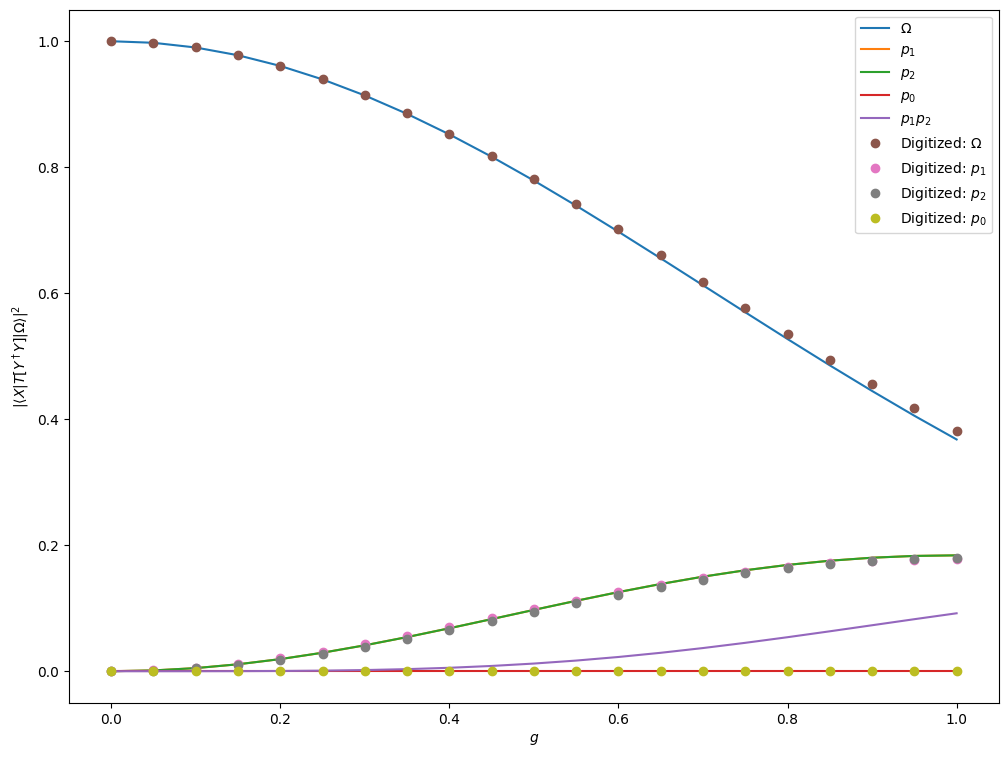

In [32]:
plt.figure(figsize=(12,9))
plt.plot(gvals,state000vals, label=r'$\Omega$')
plt.plot(gvals,state100vals, label=r'$p_1$')
plt.plot(gvals,state001vals, label=r'$p_2$')
plt.plot(gvals,state010vals, label=r'$p_0$')
plt.plot(gvals,state101vals, label=r'$p_1 p_2$')
plt.plot(gvals,ham000vals, label=r'Digitized: $\Omega$',marker='o',ls="none")
plt.plot(gvals,ham100vals, label=r'Digitized: $p_1$',marker='o',ls="none")
plt.plot(gvals,ham001vals, label=r'Digitized: $p_2$',marker='o',ls="none")
plt.plot(gvals,ham010vals, label=r'Digitized: $p_0$',marker='o',ls="none")
plt.xlabel(r'$g$')
plt.ylabel(r'$|\langle X | T[Y^\dagger Y] | \Omega \rangle|^2$')
plt.legend()

### Qiskit cross check

In [33]:
# Basic initialization
%matplotlib inline
import math
import numpy as np
from scipy.linalg import cholesky
import matplotlib.gridspec as gridspec

import qiskit
from qiskit import Aer, execute
from qiskit import QuantumCircuit, QuantumRegister
import sys
import os

sys.path.append("/Users/bpnachman/Desktop/Demo/lattice_qft")
print(sys.path)

from lattice_qft.core import lattice as lattice_cf
#from lattice_qft.core import settings
from lattice_qft.Scalar_Field_Theory import basic_operator_implementations as basic_op_cf
from lattice_qft.Scalar_Field_Theory import lattice_sft

import itertools

['/Users/bpnachman/Desktop/Demo/lattice_qft/lattice_qft/examples', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python311.zip', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/lib-dynload', '', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/site-packages', '/Users/bpnachman/Desktop/Demo/lattice_qft']
qiskit may not operate as intended because version 0.40.0 of qiskit is expected. Please install qiskit 0.40.0 instead of 0.43.1 which may is depreciated/appreciated.
['/Users/bpnachman/Desktop/Demo/lattice_qft/lattice_qft/examples', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python311.zip', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/lib-dynload', '', '/Users/bpnachman/opt/anaconda3/envs/Tutorial/lib/python3.11/site-packages', '/Users/bpnachman/Desktop/Demo/lattice_qft']
good


In [34]:
simulator = Aer.get_backend('unitary_simulator')
simulator_state = Aer.get_backend('statevector_simulator')

In [35]:
# Define the lattice to be used
Lat.nQ = 2

dim = 1
num_ancilla = 1
lattice = lattice_sft.sft_lattice(dim, Lat.nL, Lat.dx, Lat.nQ, num_ancilla)
#lattice = lattice_sft.Lattice(lattice_obj)
#Define the phi_max value
#settings.phi_max = Lat.phiMax

In [36]:
# Build ground state circuit


qc_ground = QuantumCircuit(lattice.get_q_register())
#ground_state.build()
ground_state = lattice.ground_state(qc_ground, lattice.get_q_register())

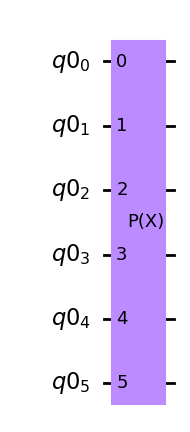

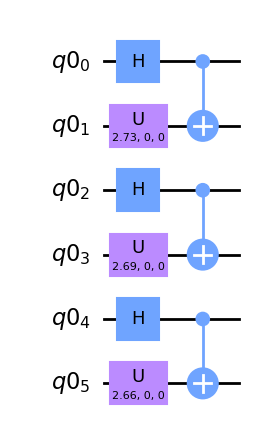

In [37]:
display(qc_ground.draw('mpl'))

for op in qc_ground.data:
    if op[0].name == 'u':
        print(op[0].params)
        
QC_state_prep = QuantumCircuit(lattice.get_q_register())

QC_state_prep.h([0,2,4])
QC_state_prep.u(np.pi/2+1.160875390968804,0,0, 1)
QC_state_prep.u(np.pi/2+1.1199447401416376,0,0, 3)
QC_state_prep.u(np.pi/2+1.0935884106090699,0,0, 5)
for qubit in range(3):
    QC_state_prep.cx(2*qubit, 2*qubit+1)

display(QC_state_prep.draw('mpl'))

In [38]:
# Some code to try to simplfy excited states. Doesn't help much
from lattice_qft.core import distributions

def sum_paramexps(paramexps):
    total = 0
    for i in paramexps:
        total += np.abs(float(i))
    return total


def simplifyrotations(qc):
    modified_qc = QuantumCircuit()
    for qreg in qc.qregs:
        modified_qc.add_register(qreg)
    #print(sum_paramexps(qc.data[0][0].params))
    for op in qc.data:
        if op[0].name == 'cx':
            modified_qc.cx(*op[1])
        elif op[0].name == 'u1':
            #print(op[0].params)
            if sum_paramexps((op[0].params)) >= 0.15:
                modified_qc.p(*op[0].params, op[1][0])
        elif op[0].name == 'u2':
            print(op[0].params)
            if sum_paramexps(op[0].params) >= 0.15:
                modified_qc.u2(*op[0].params, op[1][0]) #replace with modified_qc.u(pi/2, *op[0].params, op[1][0])
            else:
                modified_qc.u2(0,0 , op[1][0])
        elif op[0].name == 'u3':
            #print(op[0].params)
            if sum_paramexps(op[0].params) >= 0.15:
                if np.abs(float(op[0].params[0]) - np.pi/2) <= 0.001:
                    modified_qc.u2(op[0].params[1], op[0].params[2], op[1][0])
                else:
                    modified_qc.u(*op[0].params, op[1][0])
                
    modified_qc = qiskit.transpile(modified_qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)  
    return modified_qc

build_state = adagop(0, Lat) @ createKWground(Lat)

#init_state = qiskit.aqua.components.initial_states.Custom(Lat.nL*Lat.nQ,state_vector=build_state)
init_qc = QuantumCircuit(Lat.nL*Lat.nQ)
init_state = distributions.UnivariateDistribution(Lat.nL*Lat.nQ, build_state)
init_state.build(init_qc)
#init_qc = init_qc.decompose().decompose().decompose().decompose().decompose()
#display(init_qc.draw('mpl'))

opt_init_qc = qiskit.transpile(init_qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

modified_qc = simplifyrotations(opt_init_qc)
#display(modified_qc.draw('mpl'))    

print(init_qc.count_ops())
print(opt_init_qc.count_ops())
print(modified_qc.count_ops())
#display(modified_qc.draw('mpl'))

OrderedDict([('initialize', 1)])
OrderedDict([('cx', 114), ('u3', 63), ('u1', 57)])
OrderedDict([('cx', 76), ('u3', 58)])


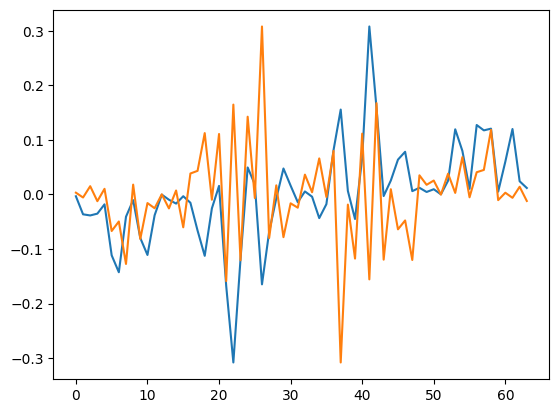

In [39]:
# Check what circuit reduction is actually doing
result = execute(init_qc, simulator_state).result()
statevector = result.get_statevector()

result_direct = execute(opt_init_qc.reverse_bits(), simulator_state).result()
statevector_direct = result_direct.get_statevector()

plt.plot(np.real(statevector))
plt.plot(np.real(-statevector_direct))

In [40]:
result = execute(qc_ground, simulator_state).result()
statevector = result.get_statevector(qc_ground)

In [41]:
def qubit_vals(mycounts,nq_persite,nsites):
    #mycounts = result.get_counts()
    
    myout = np.zeros(nsites*2**nq_persite)
    for mysite in range(nsites):
        for i in range(2**nq_persite):
            for mystate in mycounts:
                if (mystate[nq_persite*mysite:nq_persite*(mysite+1)]==bin(i)[2:].zfill(nq_persite)):
                    myout[mysite*2**nq_persite+i]+=mycounts[mystate]
                    pass
                pass
            pass
        pass
    return myout

In [42]:
from lattice_qft.core.plot_utils import plot_persite_combined

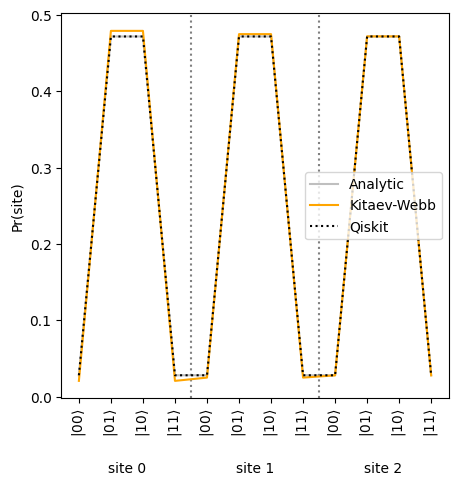

In [43]:
plot_persite_combined([abs(createEigenstate([0,0,0], Lat))**2,abs(createKWstate([0,0,0], Lat))**2,np.abs(statevector)**2],
                      Lat.nQ, Lat.nL, ["Analytic","Kitaev-Webb","Qiskit"], [False,False,True])

## Try evolving there and back again

In [44]:
#The basic operator phi^1 and pi^2
phi2 = basic_op_cf.Phi2Operator(lattice._phiMax)
print(lattice._phiMax)
pi2 = basic_op_cf.Pi2Operator(lattice._phiMax)

1.628102822756102


In [45]:
evolve_time, trotter_steps = 0.001, 1

qc_ground_nresets = QuantumCircuit(qc_ground.qubits)

for i in qc_ground.decompose():
    if i.operation.name != 'reset':
        qc_ground_nresets.append(i)
#print(qc_ground_nresets.decompose())

evolve_times = []
ground_state_prob = []
for evolve_time in np.logspace(-3,np.log(2)/np.log(10),20):
    evolve_H_Pi = QuantumCircuit(lattice.get_q_register())
    evolve_H_Phi = QuantumCircuit(lattice.get_q_register())
    t = evolve_time / trotter_steps
    for i in range(nL): #Assumes a 1d Lattice
        evolve_H_Pi.compose(lattice.apply_single_operator([[i], pi2, [t * 0.5]]),inplace=True)
        evolve_H_Phi.compose(lattice.apply_single_operator([[i], phi2, [t * 0.5 * 2 / dx**2]]), inplace=True)
        evolve_H_Phi.compose(lattice.apply_double_phi([i-1], [i], t * (-.5) / dx**2), inplace=True)
        evolve_H_Phi.compose(lattice.apply_double_phi([i+1], [i], t * (-.5) / dx**2), inplace=True)
    #print(qc_ground.draw())
    evolve_Trotter = QuantumCircuit(lattice.get_q_register())
    evolve_Trotter.compose(qc_ground, inplace=True)
    print(evolve_Trotter)
    for i in range(trotter_steps):
        evolve_hamiltonian = evolve_H_Phi.compose(evolve_H_Pi, inplace=False)
        #print(evolve_hamiltonian)
        evolve_Trotter.compose(evolve_hamiltonian, inplace=True)
        #pass
    #print(qc_ground_nresets.decompose().decompose().decompose().decompose().decompose().draw())
    evolve_Trotter.compose(qc_ground_nresets.inverse(), inplace=True)
    result = execute(evolve_Trotter, simulator_state).result()
    statevector = result.get_statevector(evolve_Trotter)
    
    evolve_times += [evolve_time]
    ground_state_prob += [abs(statevector[0])**2]

1.628102822756102
1.628102822756102
1.628102822756102
      ┌───────┐
q0_0: ┤0      ├
      │       │
q0_1: ┤1      ├
      │       │
q0_2: ┤2      ├
      │  P(X) │
q0_3: ┤3      ├
      │       │
q0_4: ┤4      ├
      │       │
q0_5: ┤5      ├
      └───────┘
1.628102822756102
1.628102822756102
1.628102822756102
      ┌───────┐
q0_0: ┤0      ├
      │       │
q0_1: ┤1      ├
      │       │
q0_2: ┤2      ├
      │  P(X) │
q0_3: ┤3      ├
      │       │
q0_4: ┤4      ├
      │       │
q0_5: ┤5      ├
      └───────┘
1.628102822756102
1.628102822756102
1.628102822756102
      ┌───────┐
q0_0: ┤0      ├
      │       │
q0_1: ┤1      ├
      │       │
q0_2: ┤2      ├
      │  P(X) │
q0_3: ┤3      ├
      │       │
q0_4: ┤4      ├
      │       │
q0_5: ┤5      ├
      └───────┘
1.628102822756102
1.628102822756102
1.628102822756102
      ┌───────┐
q0_0: ┤0      ├
      │       │
q0_1: ┤1      ├
      │       │
q0_2: ┤2      ├
      │  P(X) │
q0_3: ┤3      ├
      │       │
q0_4: ┤4      ├


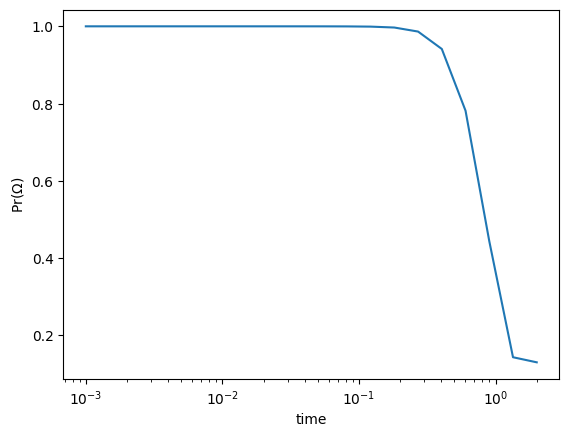

In [46]:
plt.plot(evolve_times,ground_state_prob)
plt.xlabel("time")
plt.ylabel("Pr($\Omega$)")
plt.xscale("log")

## Prepare for QC runs

In [47]:
def count_cxs(mycirc):
    mycount = 0
    if 'cx' in mycirc.count_ops():
        mycount += mycirc.count_ops()['cx']
    if 'swap' in mycirc.count_ops():
        mycount += 3*mycirc.count_ops()['swap']
    return mycount
def count_singleq(mycirc):
    mycount = 0
    for mytype in mycirc.count_ops():
        if 'cx' in mytype or 'swap' in mytype:
            continue
        else:
            mycount+=mycirc.count_ops()[mytype]
    return mycount

In [48]:
QC_nL = Lat.nL # Number of lattice sites
QC_dx = Lat.dx # Lattice spacing, usually called a in the lattice literature
QC_nQ = Lat.nQ # Number of qubits per lattice site
QC_g = 1. # Wilson line coupling constant
QC_dim = 1
QC_num_ancilla = 1

nQs = []

#CNOT + 3 x SWAP
nCs_trotter = []
nCs_state = []
nCs_wilson = []

#single qubit
nSs_trotter = []
nSs_state = []
nSs_wilson = []

for QC_nQ in range(1,5):
    
    print("on qubit=",QC_nQ)

    QC_lattice = lattice_sft.sft_lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)

    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    QC_lattice._phiMax = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)
    
    ## State prep
    QC_qc_state = QuantumCircuit(QC_lattice.get_q_register())
    QC_ground_state = QC_lattice.ground_state(QC_qc_state, QC_lattice.get_q_register())
    print(QC_qc_state.draw())
    
    #QC_ground_state.build(QC_qc_state, QC_lattice.get_q_register())

    ## Hamiltonian evolution
    evolve_time, trotter_steps = 0.001, 1
    evolve_H_Pi = QuantumCircuit(QC_lattice.get_q_register())
    evolve_H_Phi = QuantumCircuit(QC_lattice.get_q_register())
    t = evolve_time / trotter_steps
    for i in range(nL): #Assumes a 1d Lattice
        evolve_H_Pi.compose(QC_lattice.apply_single_operator([[i], pi2, [t * 0.5]]), inplace=True)
        evolve_H_Phi.compose(QC_lattice.apply_single_operator([[i], phi2, [t * 0.5 * 2 / QC_dx**2]]))
        evolve_H_Phi.compose(QC_lattice.apply_double_phi([i-1], [i], t * (-.5) / dx**2))
        evolve_H_Phi.compose(QC_lattice.apply_double_phi([i+1], [i], t * (-.5) / dx**2))
    evolve_Trotter = QuantumCircuit(QC_lattice.get_q_register())
    #evolve_Trotter += QC_qc_state
    for i in range(trotter_steps):
        evolve_hamiltonian = evolve_H_Phi.compose(evolve_H_Pi, inplace=False)
        evolve_Trotter.compose(evolve_hamiltonian, inplace=True)
        pass
    
    #Wilson line
    phi = basic_op_cf.PhiOperator(QC_lattice._phiMax)
    WL = QuantumCircuit(QC_lattice.get_q_register())
    WL.compose(QC_lattice.apply_single_operator_list([[[0],phi,[QC_g * QC_dx]],[[2],phi,[-QC_g * QC_dx]]]), inplace=True)
    print(WL)
    nQs+=[QC_nQ]
    nCs_state+=[count_cxs(QC_qc_state)]
    nCs_trotter+=[count_cxs(evolve_Trotter)]
    nCs_wilson+=[count_cxs(WL)]
    
    nSs_state+=[count_singleq(QC_qc_state)]
    nSs_trotter+=[count_singleq(evolve_Trotter)]
    nSs_wilson+=[count_singleq(WL)]

on qubit= 1
         ┌───────┐
q1154_0: ┤0      ├
         │       │
q1154_1: ┤1 P(X) ├
         │       │
q1154_2: ┤2      ├
         └───────┘
1.628102822756102
1.628102822756102
1.628102822756102
         ┌──────────────┐
q1154_0: ┤ Rz(-0.88623) ├
         └──────────────┘
q1154_1: ────────────────
         ┌─────────────┐ 
q1154_2: ┤ Rz(0.88623) ├─
         └─────────────┘ 
on qubit= 2
         ┌───────┐
q1182_0: ┤0      ├
         │       │
q1182_1: ┤1      ├
         │       │
q1182_2: ┤2      ├
         │  P(X) │
q1182_3: ┤3      ├
         │       │
q1182_4: ┤4      ├
         │       │
q1182_5: ┤5      ├
         └───────┘
1.628102822756102
1.628102822756102
1.628102822756102
         ┌──────────────┐
q1182_0: ┤ Rz(-0.62666) ├
         ├─────────────┬┘
q1182_1: ┤ Rz(-1.2533) ├─
         └─────────────┘ 
q1182_2: ────────────────
                         
q1182_3: ────────────────
         ┌─────────────┐ 
q1182_4: ┤ Rz(0.62666) ├─
         └┬────────────┤ 
q1182_5: ─┤ Rz(1.253

CNOTS ================
nQ, State, Hamiltonian
1     0      0
2     0      6
3     0     18
4     0     36


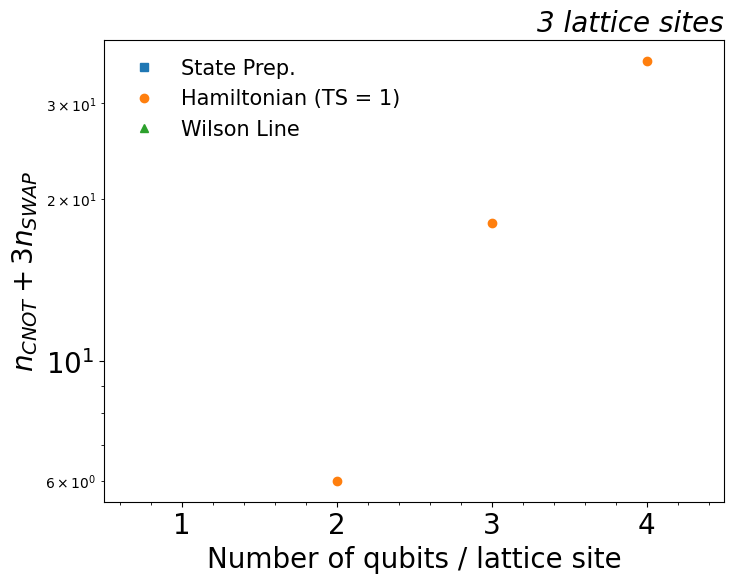

In [49]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(nQs,nCs_state,marker='s',ls="none",label="State Prep.")
plt.plot(nQs,nCs_trotter,marker='o',ls="none",label="Hamiltonian (TS = 1)")
plt.plot(nQs,nCs_wilson,marker='^',ls="none",label="Wilson Line")
plt.xlabel("Number of qubits / lattice site",fontsize=20)
plt.ylabel("$n_{CNOT} + 3 n_{SWAP}$",fontsize=20)
plt.title("3 lattice sites",style="italic",loc="right",fontsize=20)
plt.yscale("log")
plt.xticks([1,2,3,4])
plt.xlim([0.5,4.5])
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

print("CNOTS ================")
print("nQ, State, Hamiltonian")
for i in range(len(nQs)):
    print("{:1d}   {:3d}    {:3d}".format(nQs[i],nCs_state[i],nCs_trotter[i]))

Single quibit gates ===============
nQ, State, Hamiltonian, Wilson Line
1     1     54          2
2     1     93          4
3     1    141          6
4     1    198          8


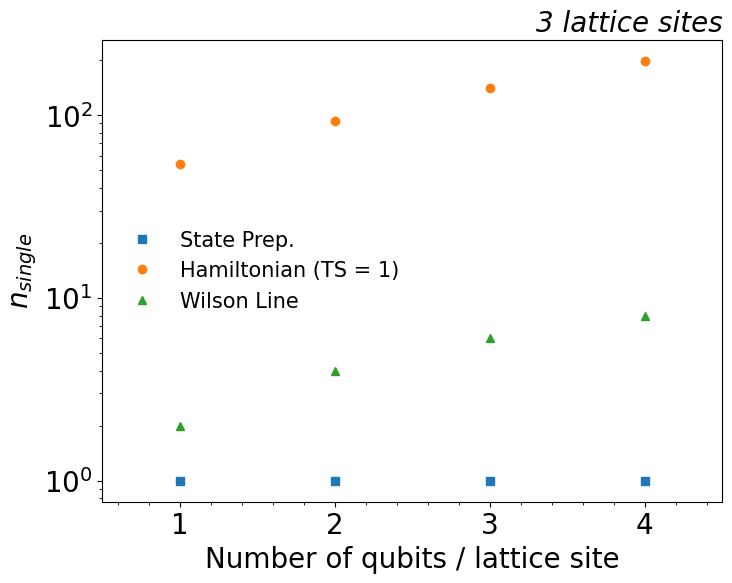

In [50]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(nQs,nSs_state,marker='s',ls="none",label="State Prep.")
plt.plot(nQs,nSs_trotter,marker='o',ls="none",label="Hamiltonian (TS = 1)")
plt.plot(nQs,nSs_wilson,marker='^',ls="none",label="Wilson Line")
plt.xlabel("Number of qubits / lattice site",fontsize=20)
plt.ylabel("$n_{single}$",fontsize=20)
plt.title("3 lattice sites",style="italic",loc="right",fontsize=20)
plt.yscale("log")
plt.xticks([1,2,3,4])
plt.xlim([0.5,4.5])
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

print("Single quibit gates ===============")
print("nQ, State, Hamiltonian, Wilson Line")
for i in range(len(nQs)):
    print("{:1d}   {:3d}    {:3d}        {:3d}".format(nQs[i],nSs_state[i],nSs_trotter[i],nSs_wilson[i]))

In [51]:
QC_lattice = lattice_sft.sft_lattice(QC_dim, QC_nL, QC_dx, 2, QC_num_ancilla)
phi = basic_op_cf.PhiOperator(QC_lattice._phiMax)
WL = QuantumCircuit(QC_lattice.get_q_register())
WL.compose(QC_lattice.apply_single_operator_list([[[0],phi,[QC_g * QC_dx]],[[2],phi,[-QC_g * QC_dx]]]), inplace=True)

In [52]:
backend = Aer.get_backend('unitary_simulator')

In [53]:
job = execute(WL, backend)
result = job.result()

In [54]:
xx = result.get_unitary(WL, decimals=3).data

print([xx[i][i].round(13) for i in range(64)])

[(1-0j), (0.467-0.884j), (-0.565-0.825j), (-0.993+0.114j), (1-0j), (0.467-0.884j), (-0.565-0.825j), (-0.993+0.114j), (1-0j), (0.467-0.884j), (-0.565-0.825j), (-0.993+0.114j), (1-0j), (0.467-0.884j), (-0.565-0.825j), (-0.993+0.114j), (0.467+0.884j), (1+0j), (0.467-0.884j), (-0.565-0.825j), (0.467+0.884j), (1+0j), (0.467-0.884j), (-0.565-0.825j), (0.467+0.884j), (1+0j), (0.467-0.884j), (-0.565-0.825j), (0.467+0.884j), (1+0j), (0.467-0.884j), (-0.565-0.825j), (-0.565+0.825j), (0.467+0.884j), (1-0j), (0.467-0.884j), (-0.565+0.825j), (0.467+0.884j), (1-0j), (0.467-0.884j), (-0.565+0.825j), (0.467+0.884j), (1-0j), (0.467-0.884j), (-0.565+0.825j), (0.467+0.884j), (1-0j), (0.467-0.884j), (-0.993-0.114j), (-0.565+0.825j), (0.467+0.884j), (1+0j), (-0.993-0.114j), (-0.565+0.825j), (0.467+0.884j), (1+0j), (-0.993-0.114j), (-0.565+0.825j), (0.467+0.884j), (1+0j), (-0.993-0.114j), (-0.565+0.825j), (0.467+0.884j), (1+0j)]


     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

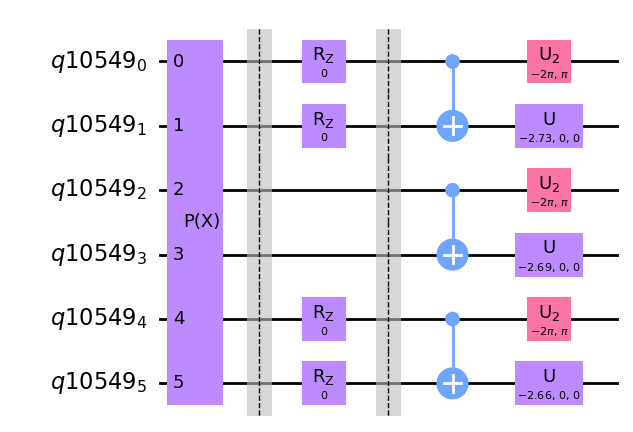

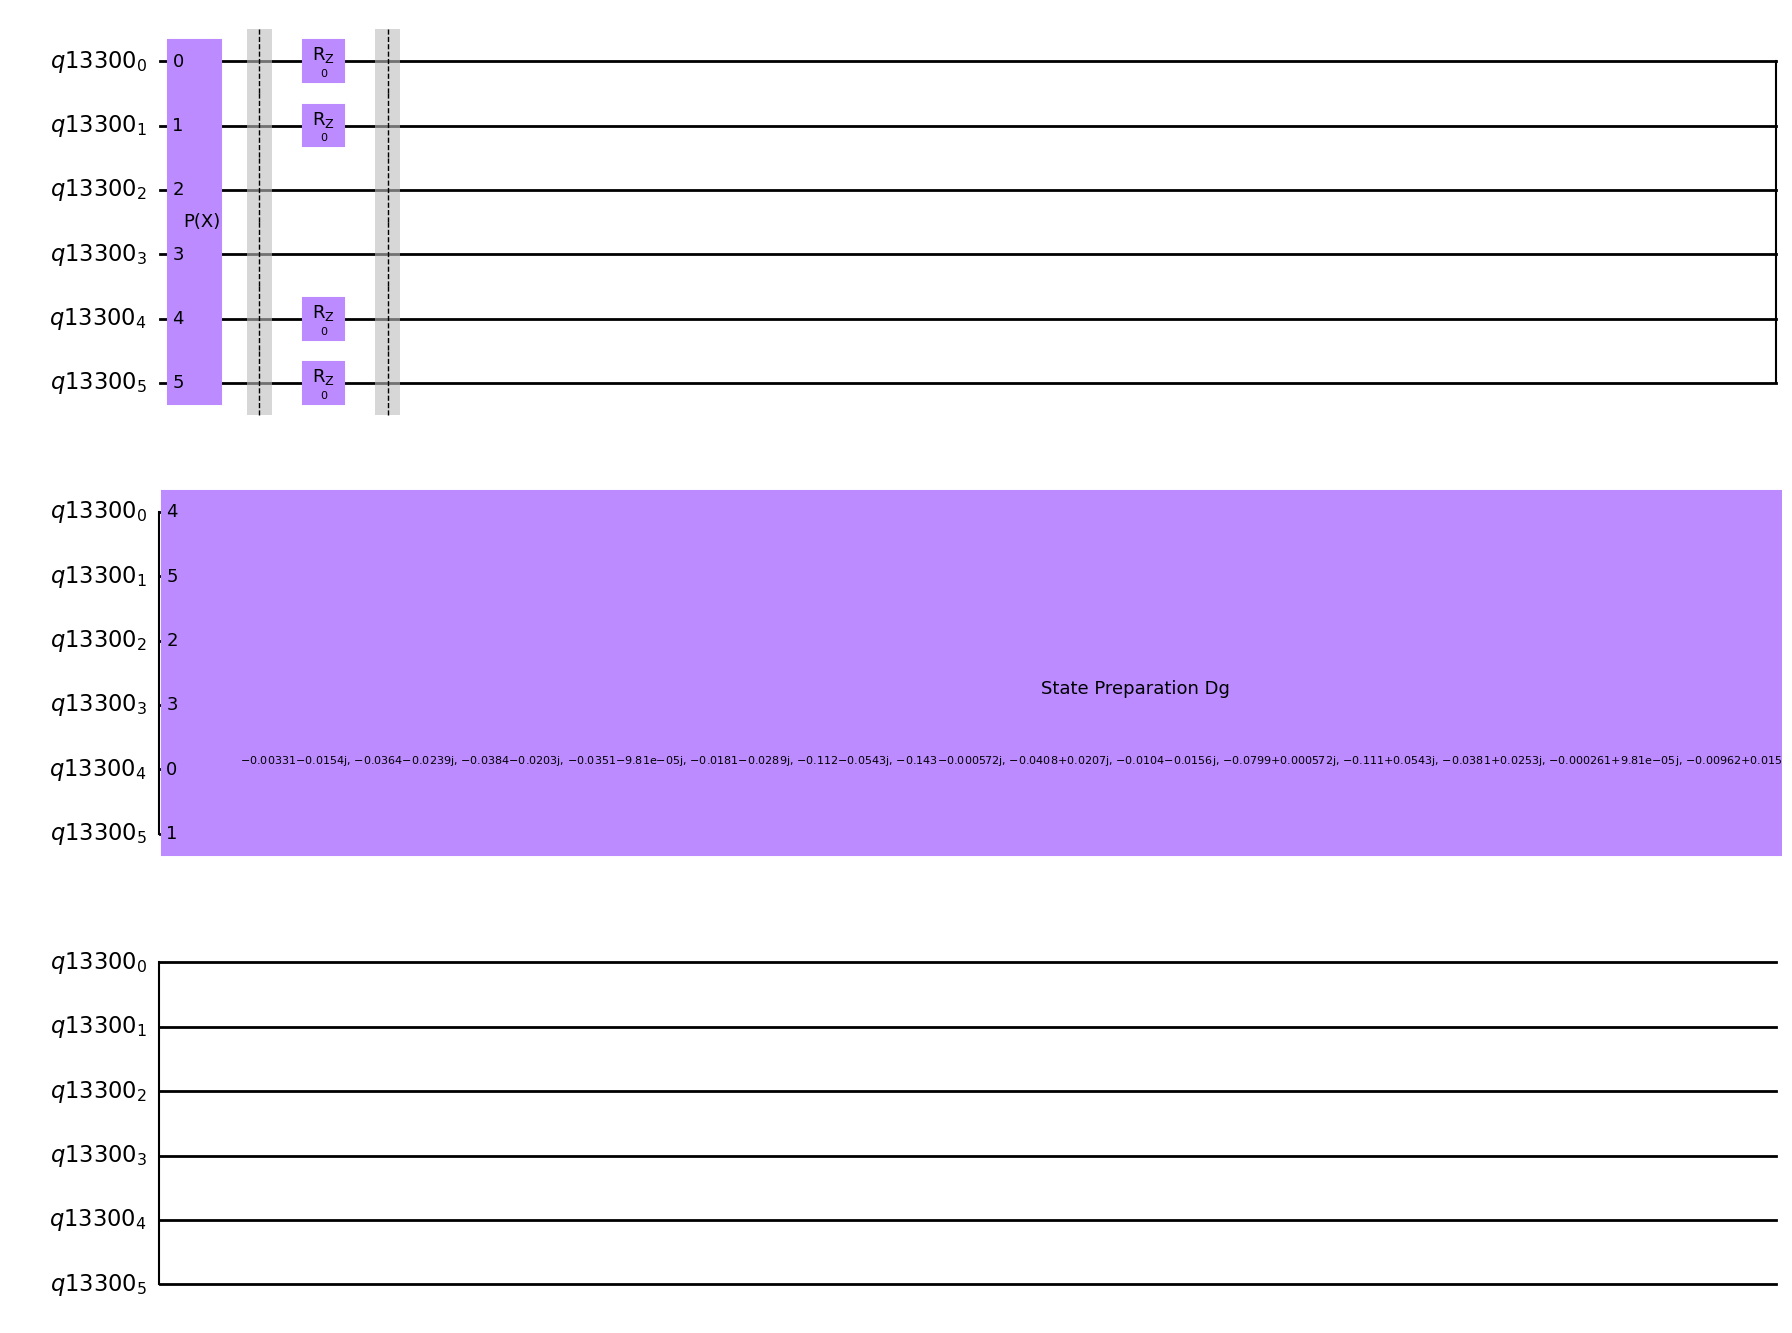

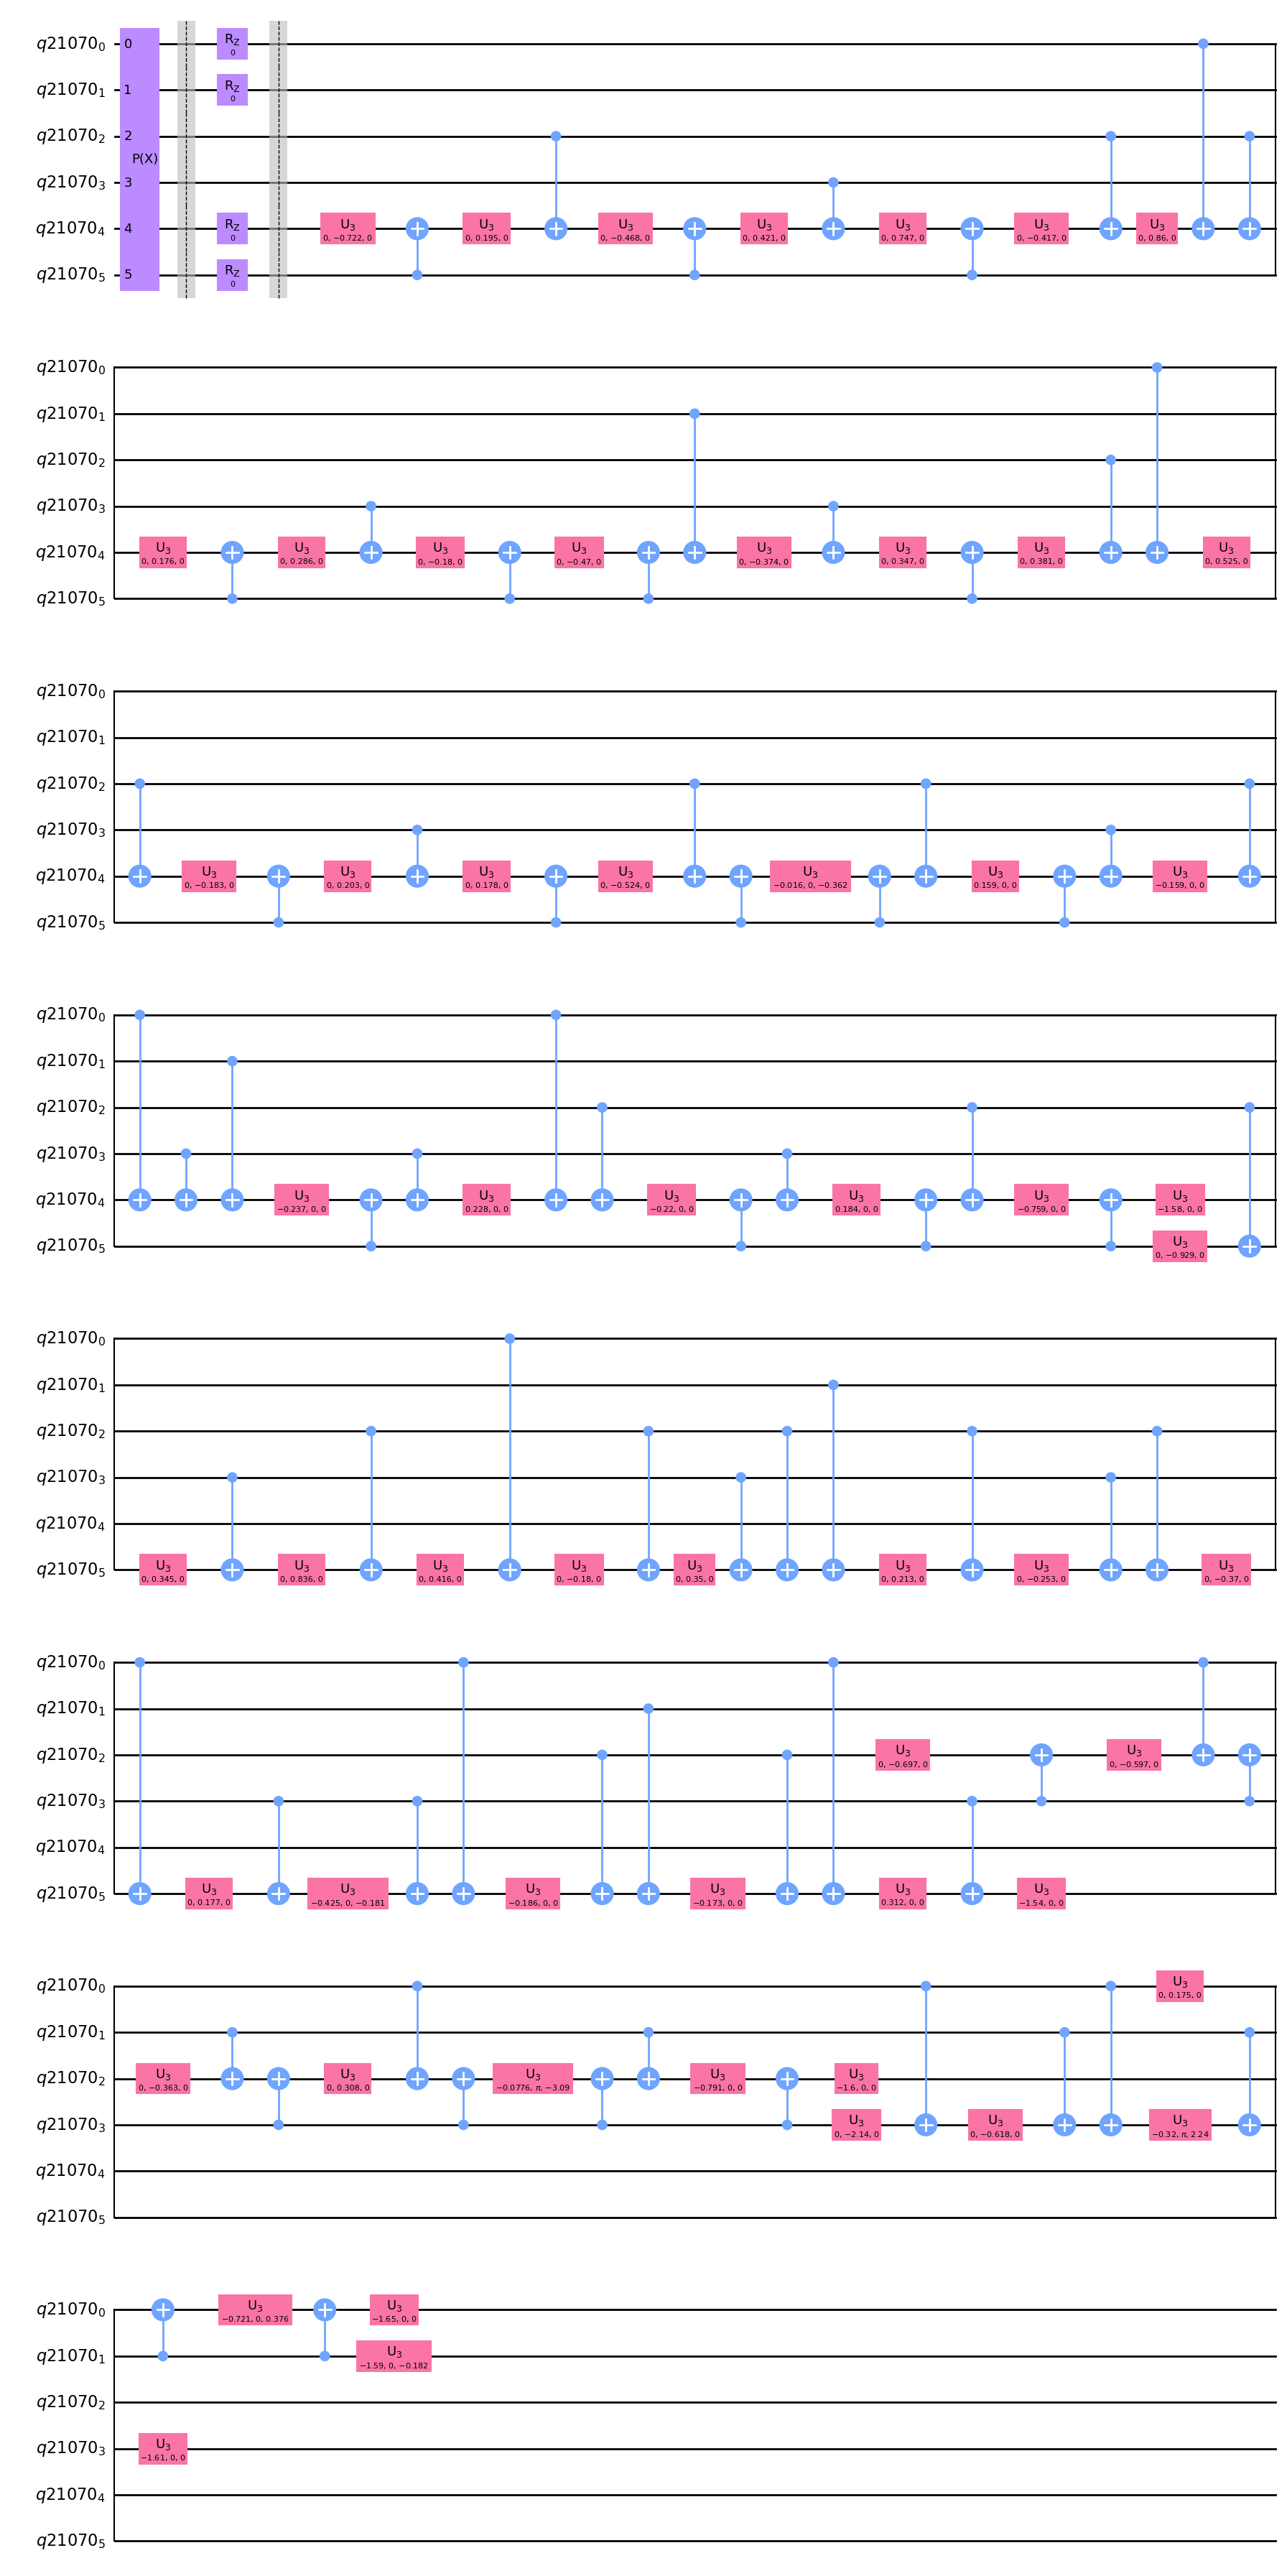

In [55]:
QC_nL = Lat.nL # Number of lattice sites
QC_dx = Lat.dx # Lattice spacing, usually called a in the lattice literature
QC_nQ = Lat.nQ # Number of qubits per lattice site
QC_g = 0.001 # Wilson line coupling constant
QC_dim = 1
QC_num_ancilla = 1


#Remove resets from Quantum Circuits
QC_state_prep_nresets = QuantumCircuit(QC_state_prep.qubits)

for i in QC_state_prep.decompose():
    if i.operation.name != 'reset':
        QC_state_prep_nresets.append(i)

qc_init_nresets = QuantumCircuit(init_qc.num_qubits)

for i in init_qc.decompose():
    if i.operation.name != 'reset':
        qc_init_nresets.append(i)
print(qc_init_nresets)
xx_sim = []
yy_runs = [[], [], []]
yy_sim = []
yy_sim_p1 = []
yy_sim_p1_approx = []
for case, run in enumerate(yy_runs):
    for QC_g in np.linspace(0,1,21):

        QC_omegalist = QC_lattice.omega_list()
        QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
        phiMax = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

        QC_lattice = lattice_sft.sft_lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
        QC = QuantumCircuit(QC_lattice.get_q_register())

        #Ground state
        QC_state_prep = QuantumCircuit(QC_lattice.get_q_register())
        QC_ground_state = QC_lattice.ground_state(QC_state_prep, QC_lattice.get_q_register())
        #QC_ground_state.build(QC_state_prep, QC_lattice.get_q_register())
        QC.compose(QC_state_prep, inplace=True)
        QC.barrier()
    
        #Wilson line
        phi = basic_op_cf.PhiOperator(phiMax)
        QC.compose(QC_lattice.apply_single_operator_list([[[0],phi,[QC_g * QC_dx]],[[2],phi,[-QC_g * QC_dx]]]), inplace=True)
        QC.barrier()
        

        #Back to the ground state
        if case == 0:
            QC.compose(QC_state_prep_nresets.inverse(), inplace=True)
        if case == 1:
            init_qc
            QC.compose(qc_init_nresets.inverse(), [4,5,2,3,0,1], inplace=True)
        if case == 2:
            QC.compose(modified_qc.inverse(), [4,5,2,3,0,1], inplace=True)
    
        if QC_g==0:
            display(QC.draw('mpl'))

        result = execute(QC, simulator_state).result()
        statevector = result.get_statevector(QC)
        if case == 0:
            xx_sim += [QC_g]
        run += [statevector[0]**2]
    
yy_sim = yy_runs[0]
yy_sim_p1 = yy_runs[1]
yy_sim_p1_approx = yy_runs[2]

In [56]:
qc_test = QuantumCircuit(2)
qc_test2 = QuantumCircuit(2)
qc_test.reset([0,1])
qc_test.h([0,1])

print((qc_test.data))

for i in qc_test:
    if i.operation.name != 'reset':
        qc_test2.data.append(i)


print(qc_test2)



[CircuitInstruction(operation=Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 1),), clbits=()), CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 1),), clbits=())]
     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘


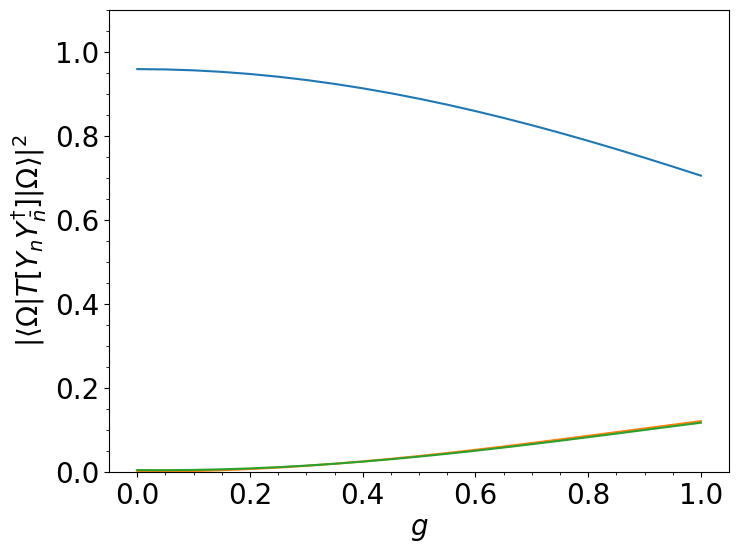

In [57]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.plot(xx_sim,np.abs(yy_sim))
plt.plot(xx_sim,np.abs(yy_sim_p1))
plt.plot(xx_sim,np.abs(yy_sim_p1_approx))
plt.ylim([0,1.1])
plt.xlabel("$g$",fontsize=20)
plt.ylabel(r"$|\langle \Omega | T[Y_{n}Y_{\bar{n}}^\dag] | \Omega\rangle|^2$",fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

In [58]:
from qiskit import IBMQ

<h1 style='color: red'>Code Not Supported Here. Update Will Come Soon</h1>

In [59]:
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q-ornl')

/var/folders/3n/qd92d1ks1ldbkqcbd2txz0fm0000gn/T/ipykernel_53543/2784805365.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account() # Load account from disk


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]


IBMQProviderError: 'No provider matches the specified criteria: hub = ibm-q-ornl, group = None, project = None'

In [ ]:
provider.backends()

In [ ]:
from qiskit.circuit import ClassicalRegister
from qiskit.compiler import transpile

In [ ]:
import lattice_qft.core.basic_circuits as bsc

In [ ]:
QC_omegalist = QC_lattice.omega_list()
QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
cr = ClassicalRegister(QC_nL*QC_nQ)
QC = QuantumCircuit(QC_lattice.get_q_register(),cr)

#Ground state
QC_ground_state = lattice_cf.ground_state(QC_lattice)
QC_state_prep = QuantumCircuit(QC_lattice.get_q_register())
QC_ground_state.build(QC_state_prep, QC_lattice.get_q_register())
QC += QC_state_prep

#Wilson line
phi = basic_op_cf.PhiOperator()
QC += QC_lattice.apply_single_operator_list([[[0],phi,[QC_g * QC_dx],False],[[2],phi,[-QC_g * QC_dx],False]])

#Back to the ground state
QC += QC_state_prep.inverse()

QC.measure(QC_lattice.get_q_register(),cr)

print("nominal,transpiled")
for myback in provider.backends():
    
    if myback.configuration().n_qubits < 6:
        continue
    
    mybackend = provider.get_backend(myback.name())
    mapped_circuit = transpile(QC, backend=mybackend)
    if 'cx' in mapped_circuit.count_ops():
        print(myback,QC.count_ops()['cx'],mapped_circuit.count_ops()['cx'])
        
    #print(myback,mapped_circuit.count_ops())

In [ ]:
backend = provider.get_backend('ibmq_manhattan')
#backend = provider.get_backend('ibmq_qasm_simulator')

QC_nL = 3 # Number of lattice sites
QC_dx = 1 # Lattice spacing, usually called a in the lattice literature
QC_nQ = 2 # Number of qubits per lattice site
QC_g = 1 # Wilson line coupling constant
QC_dim = 1
QC_num_ancilla = 1

circs = []
xx=[]
yy=[]
for QC_g in np.linspace(0.001,1,5):
    
    print("coupling = ",QC_g)

    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    cr = ClassicalRegister(QC_nL*QC_nQ)
    QC = QuantumCircuit(QC_lattice.get_q_register(),cr)

    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice)
    QC_state_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_ground_state.build(QC_state_prep, QC_lattice.get_q_register())
    QC += QC_state_prep

    #Wilson line
    phi = basic_op_cf.PhiOperator()
    QC += QC_lattice.apply_single_operator_list([[[0],phi,[QC_g * QC_dx],False],[[2],phi,[-QC_g * QC_dx],False]])

    #Back to the ground state
    QC += QC_state_prep.inverse()
    
    QC.measure(QC_lattice.get_q_register(),cr)
    
    #submit job
    mapped_circuit = transpile(QC, backend=backend) #, optimization_level=0)
    #qobj = assemble(mapped_circuit, backend=backend, shots=(8*1024))
    
    circs+=[mapped_circuit]
    
for QC_g in np.linspace(0.001,1,5):
    
    print("coupling = ",QC_g)

    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    cr = ClassicalRegister(QC_nL*QC_nQ)
    QC = QuantumCircuit(QC_lattice.get_q_register(),cr)

    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice)
    QC_state_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_ground_state.build(QC_state_prep, QC_lattice.get_q_register())
    QC += QC_state_prep

    #Wilson line
    phi = basic_op_cf.PhiOperator()
    QC += QC_lattice.apply_single_operator_list([[[0],phi,[QC_g * QC_dx],False],[[2],phi,[-QC_g * QC_dx],False]])

    #Back to the ground state
    QC += QC_state_prep.inverse()

    QC.measure(QC_lattice.get_q_register(),cr)
    
    #submit job
    mapped_circuit = transpile(QC, backend=backend) #, optimization_level=0)
    #qobj = assemble(mapped_circuit, backend=backend, shots=(8*1024))
    
    mapped_circuit_3x = mapped_circuit.copy()
    j = 0
    for i in range(len(mapped_circuit.data)):
        if (mapped_circuit.data[i][0].name=='cx'):
            mapped_circuit_3x.data.insert(j,mapped_circuit.data[i])
            j+=1
            mapped_circuit_3x.data.insert(j,mapped_circuit.data[i])
            j+=1
        j+=1
        
    circs+=[mapped_circuit_3x]

def mybin(input,q,r=1):
    if (r==0):
        return bin(input).split('b')[1].zfill(q) 
    else:
        return bin(input).split('b')[1].zfill(q)[::-1]

meas_cals_mine = []
for i in range(2**6):
    binnumber_initial = mybin(i,6)
    qr = QuantumRegister(6, 'qr')
    cr = ClassicalRegister(6, 'cr')
    circ = QuantumCircuit(qr, cr)
    for j in range(6):
        if (binnumber_initial[j]=='1'):
            circ.x(qr[j])
            pass
        pass
    pass
    circ.name='cal_'+binnumber_initial[::-1] #Their convention is backwards of mine.
    circ.name=circ.name
    for i in range(6):
        circ.measure(i,i)
    mapped_circuit = transpile(circ, backend=backend, optimization_level=0)
    circs+=[mapped_circuit]

In [ ]:
if (False):
    
    from qiskit.providers.ibmq.managed import IBMQJobManager
    job_manager = IBMQJobManager()
    job_set = job_manager.run(circs, backend=backend, name='myjob', shots=8192)
    print(job_set.job_set_id())
    #79edb6a75d8c451e8b9809d598c69896-1611207980795541

In [ ]:
if (False):
    #print(job_set.status())
    results = job_set.results()

In [ ]:
if (False):
    job_manager = IBMQJobManager()
    provider = IBMQ.get_provider(hub='ibm-q-ornl')
    retrieved_foo = job_manager.retrieve_job_set(job_set_id='79edb6a75d8c451e8b9809d598c69896-1611207980795541',provider=provider)
    
    results = retrieved_foo.results()
    
    for i in range(73):
        np.save("results/79edb6a75d8c451e8b9809d598c69896-1611207980795541_"+str(i)+".npy",results.get_counts(i))

In [ ]:
myres = {}
for i in range(74):
    myres[i] = np.load("results/79edb6a75d8c451e8b9809d598c69896-1611207980795541_"+str(i)+".npy",allow_pickle=True)

In [ ]:
'''
nominal = [results.get_counts(0)['000000']/8192,
           results.get_counts(1)['000000']/8192,
           results.get_counts(2)['000000']/8192,
           results.get_counts(3)['000000']/8192,
           results.get_counts(4)['000000']/8192]
nominal3x = [results.get_counts(5)['000000']/8192,
           results.get_counts(6)['000000']/8192,
           results.get_counts(7)['000000']/8192,
           results.get_counts(8)['000000']/8192,
           results.get_counts(9)['000000']/8192]
'''

In [ ]:
nominal = [myres[0].item()['000000']/8192,
           myres[1].item()['000000']/8192,
           myres[2].item()['000000']/8192,
           myres[3].item()['000000']/8192,
           myres[4].item()['000000']/8192]
nominal3x = [myres[5].item()['000000']/8192,
           myres[6].item()['000000']/8192,
           myres[7].item()['000000']/8192,
           myres[8].item()['000000']/8192,
           myres[9].item()['000000']/8192]

In [ ]:
def mybin(input,q,r=1):
    if (r==0):
        return bin(input).split('b')[1].zfill(q) 
    else:
        return bin(input).split('b')[1].zfill(q)[::-1]

nqbits = 6

response_normalized = np.zeros((2**nqbits,2**nqbits))
response_normalized_inverted = np.zeros((2**nqbits,2**nqbits))
response = np.zeros((2**nqbits,2**nqbits))
reco = np.zeros(2**nqbits)
truth = np.zeros(2**nqbits)
response_labels = np.zeros((2**nqbits,2**nqbits))

nominals = {}
nominal3xs = {}
for i in range(5):
    nominals[i]=np.zeros(2**nqbits)
    nominal3xs[i]=np.zeros(2**nqbits)    

for j in range(2**6):
    
    binnumber = mybin(j,6)
    for k in range(5):
        if (binnumber[::-1] in myres[k].item()):
            nominals[k][j]+=myres[k].item()[binnumber[::-1]]
        if (binnumber[::-1] in myres[k+5].item()):
            nominal3xs[k][j]+=myres[k+5].item()[binnumber[::-1]]    
    
        '''
        if (binnumber[::-1] in results.get_counts(k)):
            nominals[k][j]+=results.get_counts(k)[binnumber[::-1]]
        if (binnumber[::-1] in results.get_counts(k+5)):
            nominal3xs[k][j]+=results.get_counts(k+5)[binnumber[::-1]]  
        '''
        
    #myvals = results.get_counts(10+j)
    myvals = myres[10+j].item()
    for i in range(2**6):
        binnumber_initial = mybin(i,6)
        if (binnumber_initial[::-1] in myvals):
            reco[i]+=myvals[binnumber_initial[::-1]]
            truth[j]+=myvals[binnumber_initial[::-1]]
            response_normalized[j][i] = myvals[binnumber_initial[::-1]]/8192.
            response_normalized_inverted[i][j] = myvals[binnumber_initial[::-1]]/8192.
            response[j][i] = myvals[binnumber_initial[::-1]]
            response_labels[j][i] = '%1.0f' % (100*response_normalized[j,i])
            pass
        pass
    pass

In [ ]:
f = plt.figure(figsize=(8.5, 8.5))
plt.bar(range(2**nqbits),truth,alpha=0.3,color='b',label='Truth')
plt.bar(range(2**nqbits),reco,alpha=0.3,color='r',label='Measured')

In [ ]:
import seaborn as sns

xvals = []
xlabs = []
for i in range(2**nqbits):
  xvals+=[i+0.5]
  xlabs+=[r'$|'+mybin(i,nqbits)+r'\rangle$']
  pass

f = plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
ax = sns.heatmap(response_normalized,annot=response_labels,annot_kws={"size": 8},cmap="Blues")
ax.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax.collections[0].colorbar
cbar.set_label('Pr(Measured | True) [%]', labelpad=30)
plt.xticks(xvals,xlabs,rotation='vertical',fontsize=10)
plt.yticks(xvals,xlabs,rotation='horizontal',fontsize=10)
plt.xlabel('True',fontsize=18)
plt.ylabel('Measured',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)
#plt.savefig("Response6qubits.pdf",bbox_inches='tight')

In [ ]:
def IBU(ymes,t0,Rin,n):
    #This is the iterative Bayesian unfolding method.
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    #n is the number of iterations.
    
    tn = t0
    for q in range(n):
        out = []
        for j in range(len(t0)):
            mynum = 0.
            for i in range(len(ymes)):
                myden = 0.
                for k in range(len(t0)):
                    myden+=Rin[i][k]*tn[k]
                    pass
                if (myden==0):
                    pass
                else:
                    mynum+=Rin[i][j]*tn[j]*ymes[i]/myden
                pass
            out+=[mynum]
        tn = out
        pass
    return tn

In [ ]:
unfolded_IBU_r = IBU(reco,truth,response_normalized_inverted,20)
readout_corrected = {}
for i in range(5):
    print(i)
    readout_corrected[i] = IBU(nominals[i],truth,response_normalized_inverted,20)
readout_corrected3x = {}
for i in range(5):
    print(i)
    readout_corrected3x[i] = IBU(nominal3xs[i],truth,response_normalized_inverted,20)

In [ ]:
nominal_readoutcor = [readout_corrected[0][0]/8192,
           readout_corrected[1][0]/8192,
           readout_corrected[2][0]/8192,
           readout_corrected[3][0]/8192,
           readout_corrected[4][0]/8192]
nominal3x_readoutcor = [readout_corrected3x[0][0]/8192,
           readout_corrected3x[1][0]/8192,
           readout_corrected3x[2][0]/8192,
           readout_corrected3x[3][0]/8192,
           readout_corrected3x[4][0]/8192]

In [ ]:
f = plt.figure(figsize=(8.5, 8.5))
plt.bar(range(2**nqbits),truth,alpha=0.3,color='b',label='Truth')
#plt.bar(range(2**nqbits),reco,alpha=0.3,color='r',label='Measured')
plt.bar(range(2**nqbits),unfolded_IBU_r,alpha=0.3,color='r',label='Unfolded')

In [ ]:
nominal = np.array(nominal)
nominal_readoutcor = np.array(nominal_readoutcor)
nominal3x = np.array(nominal3x)
nominal3x_readoutcor = np.array(nominal3x_readoutcor)

In [ ]:
xxb = []
for QC_g in np.linspace(0,1,5):
    xxb += [QC_g]

## New runs

In [ ]:
myres = {}
for i in range(84):
    myres[i] = np.load("results/2414865d0b9d440494b1f177079aeafd-1629135801776319_"+str(i)+".npy",allow_pickle=True)

In [ ]:
#Mapping of qubits
qs = {}
qs[0] = 60
qs[1] = 61
qs[2] = 39
qs[3] = 9
qs[4] = 47
qs[5] = 53

In [ ]:
def subcomputer(myinput):
    myout = {}
    for mystate in myinput.item():
        subcirq = ''
        for i in range(6):
            subcirq += str(mystate[64-qs[i]])
        if (subcirq in myout):
            myout[subcirq] += myinput.item()[mystate]
        else:
            myout[subcirq] = myinput.item()[mystate]
        pass
    return myout

In [ ]:
myres4 = []
for i in range(len(myres)):
    myres4 += [subcomputer(myres[i])]

In [ ]:
nominal_new2 = [myres4[0]['000000']/8192,
           myres4[1]['000000']/8192,
           myres4[2]['000000']/8192,
           myres4[3]['000000']/8192,
           myres4[4]['000000']/8192]
nominal_new2_3x = [myres4[5]['000000']/8192,
           myres4[6]['000000']/8192,
           myres4[7]['000000']/8192,
           myres4[8]['000000']/8192,
           myres4[9]['000000']/8192]

In [ ]:
nominals_new2 = {}
nominal3xs_new2 = {}
for i in range(5):
    nominals_new2[i]=np.zeros(2**6)
    nominal3xs_new2[i]=np.zeros(2**6)
            
for j in range(2**6):
    binnumber = mybin(j,6)
    for k in range(5):
        if (binnumber in myres4[k]):
            nominals_new2[k][j]+=myres4[k][binnumber]
        if (binnumber in myres4[k+5]):
            nominal3xs_new2[k][j]+=myres4[k+5][binnumber] 
    
response_normalized_inverted6 = np.zeros((2**6,2**6)) 
truth6 = np.zeros(2**6)
for j in range(2**6):
    binnumber = mybin(j,6)
    myvals = myres4[10+j]
    for i in range(2**6):
        binnumber_initial = mybin(i,6)
        if (binnumber_initial in myvals):
            response_normalized_inverted6[i][j] = myvals[binnumber_initial]/8192.
            truth6[j]+=myvals[binnumber_initial]
            pass
        pass
    pass

In [ ]:
readout_corrected_new2 = {}
for i in range(5):
    print(i)
    readout_corrected_new2[i] = IBU(nominals_new2[i],truth6,response_normalized_inverted6,20)
readout_corrected3x_new2 = {}
for i in range(5):
    print(i)
    readout_corrected3x_new2[i] = IBU(nominal3xs_new2[i],truth6,response_normalized_inverted6,20)

In [ ]:
nominal_new_rc = np.array([readout_corrected_new2[0][0]/8192,
           readout_corrected_new2[1][0]/8192,
           readout_corrected_new2[2][0]/8192,
           readout_corrected_new2[3][0]/8192,
           readout_corrected_new2[4][0]/8192])
nominal_new_3x_rc = np.array([readout_corrected3x_new2[0][0]/8192,
           readout_corrected3x_new2[1][0]/8192,
           readout_corrected3x_new2[2][0]/8192,
           readout_corrected3x_new2[3][0]/8192,
           readout_corrected3x_new2[4][0]/8192])

## End new runs

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

CWB = np.array([[0., 1.], [0.1, 0.991849], [0.2, 0.967779], [0.3, 0.928902], [0.4,0.876983], [0.5, 0.814305], [0.6, 0.743505], [0.7, 0.667401], [0.8,0.588805], [0.9, 0.510363], [1., 0.434416]])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

#plt.plot(CWB[:,0],CWB[:,1],lw=1,label="Analytic Calculation",color="blue")
plt.plot(gvals, state000vals, lw=1, label='Analytic Calculation', color='blue')
plt.plot(xx_sim,yy_sim,label="Digitized Calculation/Noiseless Simulation (Qiskit)",ls=":",lw=5,color="orange")
#plt.plot(xxb,nominal,label="Raw Quantum (IBMQ)",marker='s',ms=10,ls="",color="green")
plt.plot(xxb,nominal_new2,label="Raw Quantum (IBMQ)",marker='s',ms=10,ls="",color="green")
#plt.plot(xxb,nominal_readoutcor,label="Nominal + Readout")
#plt.plot(xxb,nominal3x,label="(3 cx)")
#plt.plot(xxb,nominal3x_readoutcor,label="(3 cx) + Readout")
plt.plot(gvals, state100vals, lw=1, color='blue')
plt.plot(xx_sim,yy_sim_p1_approx, ls=":",lw=5,color="orange")
#plt.plot(xxb,1.5*nominal_readoutcor-0.5*nominal3x_readoutcor,label="Corrected Quantum (IBMQ)",ls="",marker='o',color='black',ms=10)
corquantum = 1.5*nominal_new_rc-0.5*nominal_new_3x_rc
plt.plot(xxb,corquantum,label="Corrected Quantum (IBMQ)",ls="",marker='o',color='black',ms=10)
myerror = (1.5**2*(1/8192.)+0.5**2*(1/8192.))**0.5
for i in range(len(xxb)):
    plt.fill_between([xxb[i]-0.03,xxb[i]+0.03],[(1-myerror)*corquantum[i]],[(1+myerror)*corquantum[i]],alpha=0.1,color="black")
plt.legend(frameon=False,fontsize=14,ncol=1, loc='lower left', bbox_to_anchor=(0., 0.125))
plt.text(0.85,0.6, '$X = |\Omega\\rangle$', fontsize=18)
plt.text(0.85,0.065, '$X = |p_1\\rangle$', fontsize=18)

#plt.plot(CWB[:,0],CWB[:,1],ls=":",lw=5,label="Analytic")
#plt.plot(xx,yy,label="Simulation")
#plt.plot(xxb,yyb,marker='o',ls="none",label="IBMQ (Manhattan)")
plt.ylim([0,1.1])
plt.xlabel("Coupling Constant, $g$",fontsize=20)
plt.ylabel("Transition rate \n $|\langle X | \mathrm{T}[Y_{n}Y_{\\bar{n}}^\dag] | \Omega\\rangle|^2$",fontsize=20) # $|\langle \Omega | T[Y_{n}Y_{\bar{n}}^\dag] | \Omega\rangle|^2$",fontsize=20)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.savefig("Vac2Vac_v_g_v2.pdf",bbox_inches='tight')

In [ ]:
device = provider.get_backend('ibmq_manhattan')
coupling_map = device.configuration().coupling_map
coupling_map

## Other paper plots

In [ ]:
import seaborn as sns

In [ ]:
gvals = np.linspace(0,1,21)

state000_q1 = createEigenstate([0,0,0], Lat1)
state000_q2 = createEigenstate([0,0,0], Lat2)
state000_q2KW = createKWground(Lat2)
state000_q2KWo = createKWground(Lat2, decompose_shear=True)
state000_q3 = createEigenstate([0,0,0], Lat3)
state000_q3KW = createKWground(Lat3)
state000_q3KWo = createKWground(Lat3, decompose_shear=True)
state100_q1 = createEigenstate([1,0,0], Lat1)
state100_q2 = createEigenstate([1,0,0], Lat2)
state100_q2KW = adagop(0, Lat2) @ state000_q2KW
state100_q2KWo = adagop(0, Lat2) @ state000_q2KWo
state100_q3 = createEigenstate([1,0,0], Lat3)
state100_q3KW = adagop(0, Lat3) @ state000_q3KW
state100_q3KWo = adagop(0, Lat3) @ state000_q3KWo

ham000vals_q1 = [np.abs(state000_q1.conj() @ WilsonNoEvolve(g, Lat1) @ state000_q1)**2 for g in gvals]
ham000vals_q2 = [np.abs(state000_q2.conj() @ WilsonNoEvolve(g, Lat2) @ state000_q2)**2 for g in gvals]
ham000vals_q2KW = [np.abs(state000_q2KW.conj() @ WilsonNoEvolve(g, Lat2) @ state000_q2KW)**2 for g in gvals]
ham000vals_q2KWo = [np.abs(state000_q2KWo.conj() @ WilsonNoEvolve(g, Lat2) @ state000_q2KWo)**2 for g in gvals]
ham000vals_q3 = [np.abs(state000_q3.conj() @ WilsonNoEvolve(g, Lat3) @ state000_q3)**2 for g in gvals]
ham000vals_q3KW = [np.abs(state000_q3KW.conj() @ WilsonNoEvolve(g, Lat3) @ state000_q3KW)**2 for g in gvals]
ham000vals_q3KWo = [np.abs(state000_q3KWo.conj() @ WilsonNoEvolve(g, Lat3) @ state000_q3KWo)**2 for g in gvals]
ham100vals_q1 = [np.abs(state100_q1.conj() @ WilsonNoEvolve(g, Lat1) @ state000_q1)**2 for g in gvals]
ham100vals_q2 = [np.abs(state100_q2.conj() @ WilsonNoEvolve(g, Lat2) @ state000_q2)**2 for g in gvals]
ham100vals_q2KW = [np.abs(state100_q2KW.conj() @ WilsonNoEvolve(g, Lat2) @ state000_q2KW)**2 for g in gvals]
ham100vals_q2KWo = [np.abs(state100_q2KWo.conj() @ WilsonNoEvolve(g, Lat2) @ state000_q2KWo)**2 for g in gvals]
ham100vals_q3 = [np.abs(state100_q3.conj() @ WilsonNoEvolve(g, Lat3) @ state000_q3)**2 for g in gvals]
ham100vals_q3KW = [np.abs(state100_q3KW.conj() @ WilsonNoEvolve(g, Lat3) @ state000_q3KW)**2 for g in gvals]
ham100vals_q3KWo = [np.abs(state100_q3KWo.conj() @ WilsonNoEvolve(g, Lat3) @ state000_q3KWo)**2 for g in gvals]
                     
state000vals = [transrate(g, 3, [0,0,0]) for g in gvals]
state100vals = [transrate(g, 3, [1,0,0]) for g in gvals]

In [ ]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.plot(gvals, state000vals, lw=1, label='Analytic calculation', color='blue')
plt.plot([], [], ' ', label="Digitized calculations",color='white')
plt.plot(gvals, ham000vals_q1,label="  $n_Q = 1$",marker='s',ms=4,ls="",color="red")
plt.plot(gvals, ham000vals_q2,label="  $n_Q = 2$",marker='s',ms=4,ls="",color="orange")
plt.plot(gvals, ham000vals_q3,label="  $n_Q = 3$",marker='s',ms=4,ls="",color="green")
plt.plot(gvals, state100vals, lw=1, color='blue')
plt.plot(gvals, ham100vals_q1, marker='s',ms=4,ls="",color="red")
plt.plot(gvals, ham100vals_q2, marker='s',ms=4,ls="",color="orange")
plt.plot(gvals, ham100vals_q3, marker='s',ms=4,ls="",color="green")
plt.legend(frameon=False,fontsize=14,ncol=1)
plt.text(0.8,0.625, '$X = \Omega$', fontsize=18)
plt.text(0.8,0.065, '$X = p_1$', fontsize=18)

#plt.plot(CWB[:,0],CWB[:,1],ls=":",lw=5,label="Analytic")
#plt.plot(xx,yy,label="Simulation")
#plt.plot(xxb,yyb,marker='o',ls="none",label="IBMQ (Manhattan)")
plt.ylim([0,1.1])
plt.xlabel("Coupling Constant, $g$",fontsize=20)
plt.ylabel("$|\langle X | \mathrm{T}[Y_{n}Y_{\\bar{n}}^\dag] | \Omega\\rangle|^2$",fontsize=20) # $|\langle \Omega | T[Y_{n}Y_{\bar{n}}^\dag] | \Omega\rangle|^2$",fontsize=20)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.savefig("nQDependence.pdf",bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.plot(gvals, state000vals, lw=1, label='Analytic calculation', color='blue')
plt.plot([], [], ' ', label="Digitized calculations")
plt.plot(gvals, ham000vals_q2,label="  exact correlations",marker='s',ms=4,ls="",color="olive")
plt.plot(gvals, ham000vals_q2KWo,label="  Kitaev–Webb",marker='*',ms=6,ls="",color="olive")
plt.plot(gvals, ham000vals_q2KW,label="  Kitaev–Webb (modified)",marker='*',ms=6,ls="",color="maroon")
plt.plot(gvals, state100vals, lw=1, color ='blue')
plt.plot(gvals, ham100vals_q2, marker='s',ms=4,ls="",color="olive")
plt.plot(gvals, ham100vals_q2KW, marker='*',ms=6,ls="",color="olive")
plt.plot(gvals, ham100vals_q2KWo, marker='*',ms=6,ls="",color="maroon")
#plt.legend(frameon=False,fontsize=14,ncol=1, loc='lower left', bbox_to_anchor=(0., 0.15))
plt.legend(frameon=False,fontsize=14,ncol=1)
plt.text(0.8,0.625, '$X = \Omega$', fontsize=18)
plt.text(0.8,0.065, '$X = p_1$', fontsize=18)
plt.text(0.85,1.0, '$n_Q = 2$', fontsize=20)

#plt.plot(CWB[:,0],CWB[:,1],ls=":",lw=5,label="Analytic")
#plt.plot(xx,yy,label="Simulation")
#plt.plot(xxb,yyb,marker='o',ls="none",label="IBMQ (Manhattan)")
plt.ylim([0,1.1])
plt.xlabel("Coupling Constant, $g$",fontsize=20)
plt.ylabel("$|\langle X | \mathrm{T}[Y_{n}Y_{\\bar{n}}^\dag] | \Omega\\rangle|^2$",fontsize=20) # $|\langle \Omega | T[Y_{n}Y_{\bar{n}}^\dag] | \Omega\rangle|^2$",fontsize=20)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.savefig("StateDependence.pdf",bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.plot(gvals, state000vals, lw=1, label='Analytic calculation', color='blue')
plt.plot([], [], ' ', label="Digitized calculations")
plt.plot(gvals, ham000vals_q3,label="  exact correlations",marker='s',ms=4,ls="",color="olive")
plt.plot(gvals, ham000vals_q3KWo,label="  Kitaev–Webb",marker='*',ms=6,ls="",color="olive")
plt.plot(gvals, ham000vals_q3KW,label="  Kitaev–Webb (modified)",marker='*',ms=6,ls="",color="maroon")
plt.plot(gvals, state100vals, lw=1, color ='blue')
plt.plot(gvals, ham100vals_q3, marker='s',ms=4,ls="",color="olive")
plt.plot(gvals, ham100vals_q3KW, marker='*',ms=6,ls="",color="olive")
plt.plot(gvals, ham100vals_q3KWo, marker='*',ms=6,ls="",color="maroon")
#plt.legend(frameon=False,fontsize=14,ncol=1, loc='lower left', bbox_to_anchor=(0., 0.15))
plt.legend(frameon=False,fontsize=14,ncol=1)
plt.text(0.8,0.625, '$X = \Omega$', fontsize=18)
plt.text(0.8,0.065, '$X = p_1$', fontsize=18)
plt.text(0.85,1.0, '$n_Q = 3$', fontsize=20)

#plt.plot(CWB[:,0],CWB[:,1],ls=":",lw=5,label="Analytic")
#plt.plot(xx,yy,label="Simulation")
#plt.plot(xxb,yyb,marker='o',ls="none",label="IBMQ (Manhattan)")
plt.ylim([0,1.1])
plt.xlabel("Coupling Constant, $g$",fontsize=20)
plt.ylabel("$|\langle X | \mathrm{T}[Y_{n}Y_{\\bar{n}}^\dag] | \Omega\\rangle|^2$",fontsize=20) # $|\langle \Omega | T[Y_{n}Y_{\bar{n}}^\dag] | \Omega\rangle|^2$",fontsize=20)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.savefig("StateDependencenQ3.pdf",bbox_inches='tight')

In [ ]:
hamEigen2 = np.sort(np.absolute(np.linalg.eig(Hamiltonian(Lat2))[0]))
hamEigen3 = np.sort(np.absolute(np.linalg.eig(Hamiltonian(Lat3))[0]))
hamEigen4 = np.sort(np.absolute(np.linalg.eig(Hamiltonian(Lat4))[0]))

excitations = list(product(list(range(Lat4.nPhi())), repeat=Lat4.nL))
hamEigenExact = [sum([(0.5 + excitations[i][j])*Lat.EModes()[j] for j in range(Lat4.nL)]) for i in range(len(excitations))]

excitations = [x for _,x in sorted(zip(hamEigenExact,excitations))]
hamEigenExact = np.sort(hamEigenExact)

In [ ]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.yscale('symlog', linthresh=0.000000001)
ax0.set_xticks(range(1,16))
ax0.set_yticks([-1e-2, -1e-4, -1e-6, -1e-8, 1e-8, 1e-6, 1e-4, 1e-2])

plt.plot(range(1,16),(hamEigen2[0:15]-hamEigenExact[0:15])/hamEigenExact[0:15],label="$n_Q = 2$",marker='s',ms=5,ls="none", color='orange')
plt.plot(range(1,16),(hamEigen3[0:15]-hamEigenExact[0:15])/hamEigenExact[0:15],label="$n_Q = 3$",marker='s',ms=5,ls="none", color='green')
plt.plot(range(1,16),(hamEigen4[0:15]-hamEigenExact[0:15])/hamEigenExact[0:15],label="$n_Q = 4$",marker='s',ms=5,ls="none", color='blue')
plt.legend(frameon=False,fontsize=14,ncol=1)

plt.axhline(0,ls=":",color="grey")
for pow in np.arange(2,10,2):
    plt.axhline(10.**-pow,ls=":",lw=1,color="lightgrey")
    plt.axhline(-10.**-pow,ls=":",lw=1,color="lightgrey")
plt.ylim([-0.9,0.9])
plt.xlim([0.5,18.5])
plt.xlabel("Eigenvalue",fontsize=20)
plt.ylabel("Fractional Error in Eigenvalue",fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.savefig("spectrum.pdf",bbox_inches='tight')

In [ ]:
tvals = np.linspace(0.0001,3,61)

groundExact = createEigenstate([0,0,0], Lat2)
groundKW = createKWground(Lat2)

Exact1Step = [np.abs(groundExact.conj() @ evolveHTrotter(t, 1 , Lat2) @ groundExact)**2 for t in tvals]
Exact5XStep = [np.abs(groundExact.conj() @ evolveHTrotter(t, math.ceil(5*t) , Lat2) @ groundExact)**2 for t in tvals]
KW1Step = [np.abs(groundKW.conj() @ evolveHTrotter(t, 1 , Lat2) @ groundKW)**2 for t in tvals]
KW5XStep = [np.abs(groundKW.conj() @ evolveHTrotter(t, math.ceil(5*t) , Lat2) @ groundKW)**2 for t in tvals]
Exact = [1. for t in tvals]

In [ ]:
QC_nL = 3 # Number of lattice sites
QC_dx = 1 # Lattice spacing, usually called a in the lattice literature
QC_nQ = 2 # Number of qubits per lattice site
QC_dim = 1
QC_num_ancilla = 1

simulator_QASM = Aer.get_backend('qasm_simulator')

tsim = np.linspace(0.2,3,15)
Exact1StepSim = np.zeros_like(tsim)
Exact1StepErr = np.zeros_like(tsim)
Exact5XStepSim = np.zeros_like(tsim)
Exact5XStepErr = np.zeros_like(tsim)

KW1StepSim = np.zeros_like(tsim)
KW1StepErr = np.zeros_like(tsim)
KW5XStepSim = np.zeros_like(tsim)
KW5XStepErr = np.zeros_like(tsim)

for tid, QC_t in enumerate(tsim):
    
    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    QC = QuantumCircuit(QC_lattice.get_q_register())

    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice, full_correlation=True)
    QC_state_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_ground_state.build(QC_state_prep, QC_lattice.get_q_register())
    QC += QC_state_prep
    QC.barrier()
    
    #Evolution
    QC_evolution = lattice_cf.evolution(QC_lattice, evolve_time=QC_t, trotter_steps=1)
    QC_evo_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_evolution.build(QC_evo_prep, QC_lattice.get_q_register())
    QC += QC_evo_prep
    QC.barrier()
    
    #Back to the ground state
    QC += QC_state_prep.inverse()
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()
    
    right_p = counts['000000']/sum(counts.values())
    total_res = sum(counts.values())
    
    Exact1StepSim[tid] = right_p
    Exact1StepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)

for tid, QC_t in enumerate(tsim):
    
    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    QC = QuantumCircuit(QC_lattice.get_q_register())

    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice, full_correlation=True)
    QC_state_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_ground_state.build(QC_state_prep, QC_lattice.get_q_register())
    QC += QC_state_prep
    QC.barrier()
    
    #Evolution
    QC_evolution = lattice_cf.evolution(QC_lattice, evolve_time=QC_t, trotter_steps=math.ceil(5*QC_t))
    QC_evo_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_evolution.build(QC_evo_prep, QC_lattice.get_q_register())
    QC += QC_evo_prep
    QC.barrier()
    
    #Back to the ground state
    QC += QC_state_prep.inverse()
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()
    
    right_p = counts['000000']/sum(counts.values())
    total_res = sum(counts.values())
    
    Exact5XStepSim[tid] = right_p
    Exact5XStepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)
    
for tid, QC_t in enumerate(tsim):
    
    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    QC = QuantumCircuit(QC_lattice.get_q_register())

    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice)
    QC_state_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_ground_state.build(QC_state_prep, QC_lattice.get_q_register())
    QC += QC_state_prep
    QC.barrier()
    
    #Evolution
    QC_evolution = lattice_cf.evolution(QC_lattice, evolve_time=QC_t, trotter_steps=1)
    QC_evo_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_evolution.build(QC_evo_prep, QC_lattice.get_q_register())
    QC += QC_evo_prep
    QC.barrier()
    
    #Back to the ground state
    QC += QC_state_prep.inverse()
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()
    
    right_p = counts['000000']/sum(counts.values())
    total_res = sum(counts.values())
    
    KW1StepSim[tid] = right_p
    KW1StepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)

for tid, QC_t in enumerate(tsim):
    
    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    QC = QuantumCircuit(QC_lattice.get_q_register())

    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice)
    QC_state_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_ground_state.build(QC_state_prep, QC_lattice.get_q_register())
    QC += QC_state_prep
    QC.barrier()
    
    #Evolution
    QC_evolution = lattice_cf.evolution(QC_lattice, evolve_time=QC_t, trotter_steps=math.ceil(5*QC_t))
    QC_evo_prep = QuantumCircuit(QC_lattice.get_q_register())
    QC_evolution.build(QC_evo_prep, QC_lattice.get_q_register())
    QC += QC_evo_prep
    QC.barrier()
    
    #Back to the ground state
    QC += QC_state_prep.inverse()
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()
    
    right_p = counts['000000']/sum(counts.values())
    total_res = sum(counts.values())
    
    KW5XStepSim[tid] = right_p
    KW5XStepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)

In [ ]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.plot(tvals, Exact1Step, label=r'$n = 1$', lw=2)
plt.plot(tvals, Exact5XStep, label=r'$n = \lceil 5t \rceil$', lw=2)
plt.plot(tvals, Exact, label=r'exact', ls=':', color='grey')

plt.errorbar(tsim, Exact1StepSim, yerr=Exact1StepErr, ls='', marker='s', ms=3, capsize=3, color='blue')
plt.errorbar(tsim, Exact5XStepSim, yerr=Exact5XStepErr, ls='', marker='s', ms=3, capsize=3, color='red')

plt.legend(frameon=False,fontsize=14,ncol=1)
plt.text(2.1,0.003, 'exact ground state', fontsize=14)

plt.xlabel("$t$",fontsize=20)
plt.ylabel(r'$|\langle \Omega | e^{iHt} | \Omega\rangle|^2$',fontsize=20)
plt.ylim([-0.04,1.04])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.savefig("overlap_exact.pdf",bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.plot(tvals, KW1Step, label=r'$n = 1$', lw=2)
plt.plot(tvals, KW5XStep, label=r'$n = \lceil 5t \rceil$', lw=2)
plt.plot(tvals, Exact, label=r'exact', ls=':', color='grey')

plt.errorbar(tsim, KW1StepSim, yerr=KW1StepErr, ls='', marker='s', ms=3, capsize=3, color='blue')
plt.errorbar(tsim, KW5XStepSim, yerr=KW5XStepErr, ls='', marker='s', ms=3, capsize=3, color='red')

plt.legend(frameon=False,fontsize=14,ncol=1)
plt.text(2.1,0.003, 'KW approximation', fontsize=14)

plt.xlabel("$t$",fontsize=20)
plt.ylabel(r'$|\langle \Omega | e^{iHt} | \Omega\rangle|^2$',fontsize=20)
plt.ylim([-0.04,1.04])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.savefig("overlap_KW.pdf",bbox_inches='tight')

In [ ]:
tvals = np.linspace(0.0001,3,61)

groundExact = createEigenstate([0,0,0], Lat2)
groundKW = createKWground(Lat2)

Exact1Step = [np.abs(groundExact.conj() @ (np.identity(Lat2.nPhi()**Lat2.nL) + evolveHTrotter(t, 1 , Lat2)) @ groundExact)**2/4 for t in tvals]
Exact5XStep = [np.abs(groundExact.conj() @ (np.identity(Lat2.nPhi()**Lat2.nL) + evolveHTrotter(t, math.ceil(5*t), Lat2)) @ groundExact)**2/4 for t in tvals]
KW1Step = [np.abs(groundKW.conj() @ (np.identity(Lat2.nPhi()**Lat2.nL) + evolveHTrotter(t, 1 , Lat2)) @ groundKW)**2/4 for t in tvals]
KW5XStep = [np.abs(groundKW.conj() @ (np.identity(Lat2.nPhi()**Lat2.nL) + evolveHTrotter(t, math.ceil(5*t), Lat2)) @ groundKW)**2/4 for t in tvals]
Exact = [np.abs(1+ np.exp(2j*t))**2/4 for t in tvals]

In [ ]:
QC_nL = 3 # Number of lattice sites
QC_dx = 1 # Lattice spacing, usually called a in the lattice literature
QC_nQ = 2 # Number of qubits per lattice site
QC_dim = 1
QC_num_ancilla = 1

simulator_QASM = Aer.get_backend('qasm_simulator')

tsim = np.linspace(0.2,3,15)
Exact1StepSim = np.zeros_like(tsim)
Exact1StepErr = np.zeros_like(tsim)
Exact5XStepSim = np.zeros_like(tsim)
Exact5XStepErr = np.zeros_like(tsim)

KW1StepSim = np.zeros_like(tsim)
KW1StepErr = np.zeros_like(tsim)
KW5XStepSim = np.zeros_like(tsim)
KW5XStepErr = np.zeros_like(tsim)

for tid, QC_t in enumerate(tsim):
    
    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    
    stateq = QC_lattice.get_q_register()
    statecontrol = QC_lattice.get_a_register()
    
    QC = QuantumCircuit(stateq, statecontrol)
    QC.h(statecontrol)
    
    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice, full_correlation=True)
    QC_state_prep = QuantumCircuit(stateq)
    QC_ground_state.build(QC_state_prep, stateq)
    QC += QC_state_prep
    QC.barrier()
    
    #Evolution
    QC_evolution = lattice_cf.evolution(QC_lattice, evolve_time=QC_t, trotter_steps=1)
    QC_evo_prep = QuantumCircuit(stateq)
    QC_evolution.build_controlled(QC_evo_prep, stateq, statecontrol[0])
    QC += QC_evo_prep
    QC.barrier()
    
    #Back to the ground state
    QC += QC_state_prep.inverse()
    QC.h(statecontrol)
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()

    right_p = counts['0000000']/sum(counts.values())
    total_res = sum(counts.values())
    
    Exact1StepSim[tid] = right_p
    Exact1StepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)

for tid, QC_t in enumerate(tsim):
    
    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    
    stateq = QC_lattice.get_q_register()
    statecontrol = QC_lattice.get_a_register()
    
    QC = QuantumCircuit(stateq, statecontrol)
    QC.h(statecontrol)
    
    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice, full_correlation=True)
    QC_state_prep = QuantumCircuit(stateq)
    QC_ground_state.build(QC_state_prep, stateq)
    QC += QC_state_prep
    QC.barrier()
    
    #Evolution
    QC_evolution = lattice_cf.evolution(QC_lattice, evolve_time=QC_t, trotter_steps=math.ceil(5*QC_t))
    QC_evo_prep = QuantumCircuit(stateq)
    QC_evolution.build_controlled(QC_evo_prep, stateq, statecontrol[0])
    QC += QC_evo_prep
    QC.barrier()
    
    #Back to the ground state
    QC += QC_state_prep.inverse()
    QC.h(statecontrol)
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()
    
    right_p = counts['0000000']/sum(counts.values()) if '0000000' in counts.keys() else 0.
    total_res = sum(counts.values())
    
    Exact5XStepSim[tid] = right_p
    Exact5XStepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)
    
for tid, QC_t in enumerate(tsim):
    
    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    
    stateq = QC_lattice.get_q_register()
    statecontrol = QC_lattice.get_a_register()
    
    QC = QuantumCircuit(stateq, statecontrol)
    QC.h(statecontrol)
    
    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice)
    QC_state_prep = QuantumCircuit(stateq)
    QC_ground_state.build(QC_state_prep, stateq)
    QC += QC_state_prep
    QC.barrier()
    
    #Evolution
    QC_evolution = lattice_cf.evolution(QC_lattice, evolve_time=QC_t, trotter_steps=1)
    QC_evo_prep = QuantumCircuit(stateq)
    QC_evolution.build_controlled(QC_evo_prep, stateq, statecontrol[0])
    QC += QC_evo_prep
    QC.barrier()
    
    #Back to the ground state
    QC += QC_state_prep.inverse()
    QC.h(statecontrol)
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()

    right_p = counts['0000000']/sum(counts.values())
    total_res = sum(counts.values())
    
    KW1StepSim[tid] = right_p
    KW1StepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)

for tid, QC_t in enumerate(tsim):
    
    QC_omegalist = QC_lattice.omega_list()
    QC_av_omega = np.sum(QC_omegalist) / QC_lattice.get_num_sites_per_dim()
    settings.phi_max = math.sqrt(math.pi/2 * (2**QC_nQ - 1)**2 / 2**QC_nQ) / math.sqrt(QC_av_omega)

    QC_lattice = lattice_cf.Lattice(QC_dim, QC_nL, QC_dx, QC_nQ, QC_num_ancilla)
    
    stateq = QC_lattice.get_q_register()
    statecontrol = QC_lattice.get_a_register()
    
    QC = QuantumCircuit(stateq, statecontrol)
    QC.h(statecontrol)
    
    #Ground state
    QC_ground_state = lattice_cf.ground_state(QC_lattice)
    QC_state_prep = QuantumCircuit(stateq)
    QC_ground_state.build(QC_state_prep, stateq)
    QC += QC_state_prep
    QC.barrier()
    
    #Evolution
    QC_evolution = lattice_cf.evolution(QC_lattice, evolve_time=QC_t, trotter_steps=math.ceil(5*QC_t))
    QC_evo_prep = QuantumCircuit(stateq)
    QC_evolution.build_controlled(QC_evo_prep, stateq, statecontrol[0])
    QC += QC_evo_prep
    QC.barrier()
    
    #Back to the ground state
    QC += QC_state_prep.inverse()
    QC.h(statecontrol)
    
    QC.measure_all()
#    if QC_t < 0.3:
#        display(QC.draw('mpl'))
    
    result = execute(QC, simulator_QASM, shots = 512).result()
    counts = result.get_counts()
    
    right_p = counts['0000000']/sum(counts.values()) if '0000000' in counts.keys() else 0.
    total_res = sum(counts.values())
    
    KW5XStepSim[tid] = right_p
    KW5XStepErr[tid] = math.sqrt(right_p *(1-right_p)/total_res)

In [ ]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.plot(tvals, Exact1Step, label=r'$n = 1$', lw=2)
plt.plot(tvals, Exact5XStep, label=r'$n = \lceil 5t \rceil$', lw=2)
plt.plot(tvals, Exact, label=r'exact', ls=':', color='grey')

plt.errorbar(tsim, Exact1StepSim, yerr=Exact1StepErr, ls='', marker='s', ms=3, capsize=3, color='blue')
plt.errorbar(tsim, Exact5XStepSim, yerr=Exact5XStepErr, ls='', marker='s', ms=3, capsize=3, color='red')

plt.legend(frameon=False,fontsize=14,ncol=1)
plt.text(2.1,0.003, 'exact ground state', fontsize=14)

plt.xlabel("$t$",fontsize=20)
plt.ylabel(r'$|\langle \Omega | 1 + e^{iHt} | \Omega\rangle|^2/4$',fontsize=20)
plt.ylim([-0.04,1.04])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.savefig("control_exact.pdf",bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.plot(tvals, KW1Step, label=r'$n = 1$', lw=2)
plt.plot(tvals, KW5XStep, label=r'$n = \lceil 5t \rceil$', lw=2)
plt.plot(tvals, Exact, label=r'exact', ls=':', color='grey')

plt.errorbar(tsim, KW1StepSim, yerr=KW1StepErr, ls='', marker='s', ms=3, capsize=3, color='blue')
plt.errorbar(tsim, KW5XStepSim, yerr=KW5XStepErr, ls='', marker='s', ms=3, capsize=3, color='red')

plt.legend(frameon=False,fontsize=14,ncol=1)
plt.text(2.1,0.003, 'KW approximation', fontsize=14)

plt.xlabel("$t$",fontsize=20)
plt.ylabel(r'$|\langle \Omega | 1 + e^{iHt} | \Omega\rangle|^2/4$',fontsize=20)
plt.ylim([-0.04,1.04])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.savefig("control_KW.pdf",bbox_inches='tight')